# Setup

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_style(style="white")
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy
import warnings
import csv
from IPython.display import display
warnings.filterwarnings('ignore')

# configure plotting
rc('text', usetex=True)
plt.rc('font', family='serif')
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'font.size': 30, \
                            'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline

In [2]:
%load_ext autoreload
%aimport networks
from networks import BAGraph
%aimport log_bin
# helper functions
%aimport utils
font_size = 20
%autoreload 1

# Fixed N and varying m

In [3]:
from collections import Counter

folder = "data/ba/deg_dist"
N = 10**6
M = [1, 2, 4, 8, 16, 32]
fixed_n_df = pd.DataFrame()
for m in M:
    print(m)
    data = []
    # number of repeats
    for i in range(1,101):
        folder_name = folder + str(i) + "/"
        filename = "{0}_{1}.txt".format(N, m)
        filepath = folder_name + filename
        with open(filepath, 'r') as f:
            reader = csv.reader(f)
            data_as_list = list(reader)
        x = data_as_list[0]
        x = [int(i) for i in x]
        data.append(x)
    counters = [Counter(x) for x in data]
    sums = dict(sum(counters, Counter()))
    data_mean = {x: float(sums[x]) / len(data) for x in sums.keys()}
    additional = pd.DataFrame.from_dict(data_mean, orient="index")
    additional.columns = [m]
    fixed_n_df = pd.concat([fixed_n_df, additional], axis=1)

1
2
4
8
16
32


In [4]:
fixed_n_degrees = fixed_n_df

for col in fixed_n_degrees:
    total = fixed_n_degrees[col].dropna().sum()
    fixed_n_degrees[col] = fixed_n_degrees[col] / total

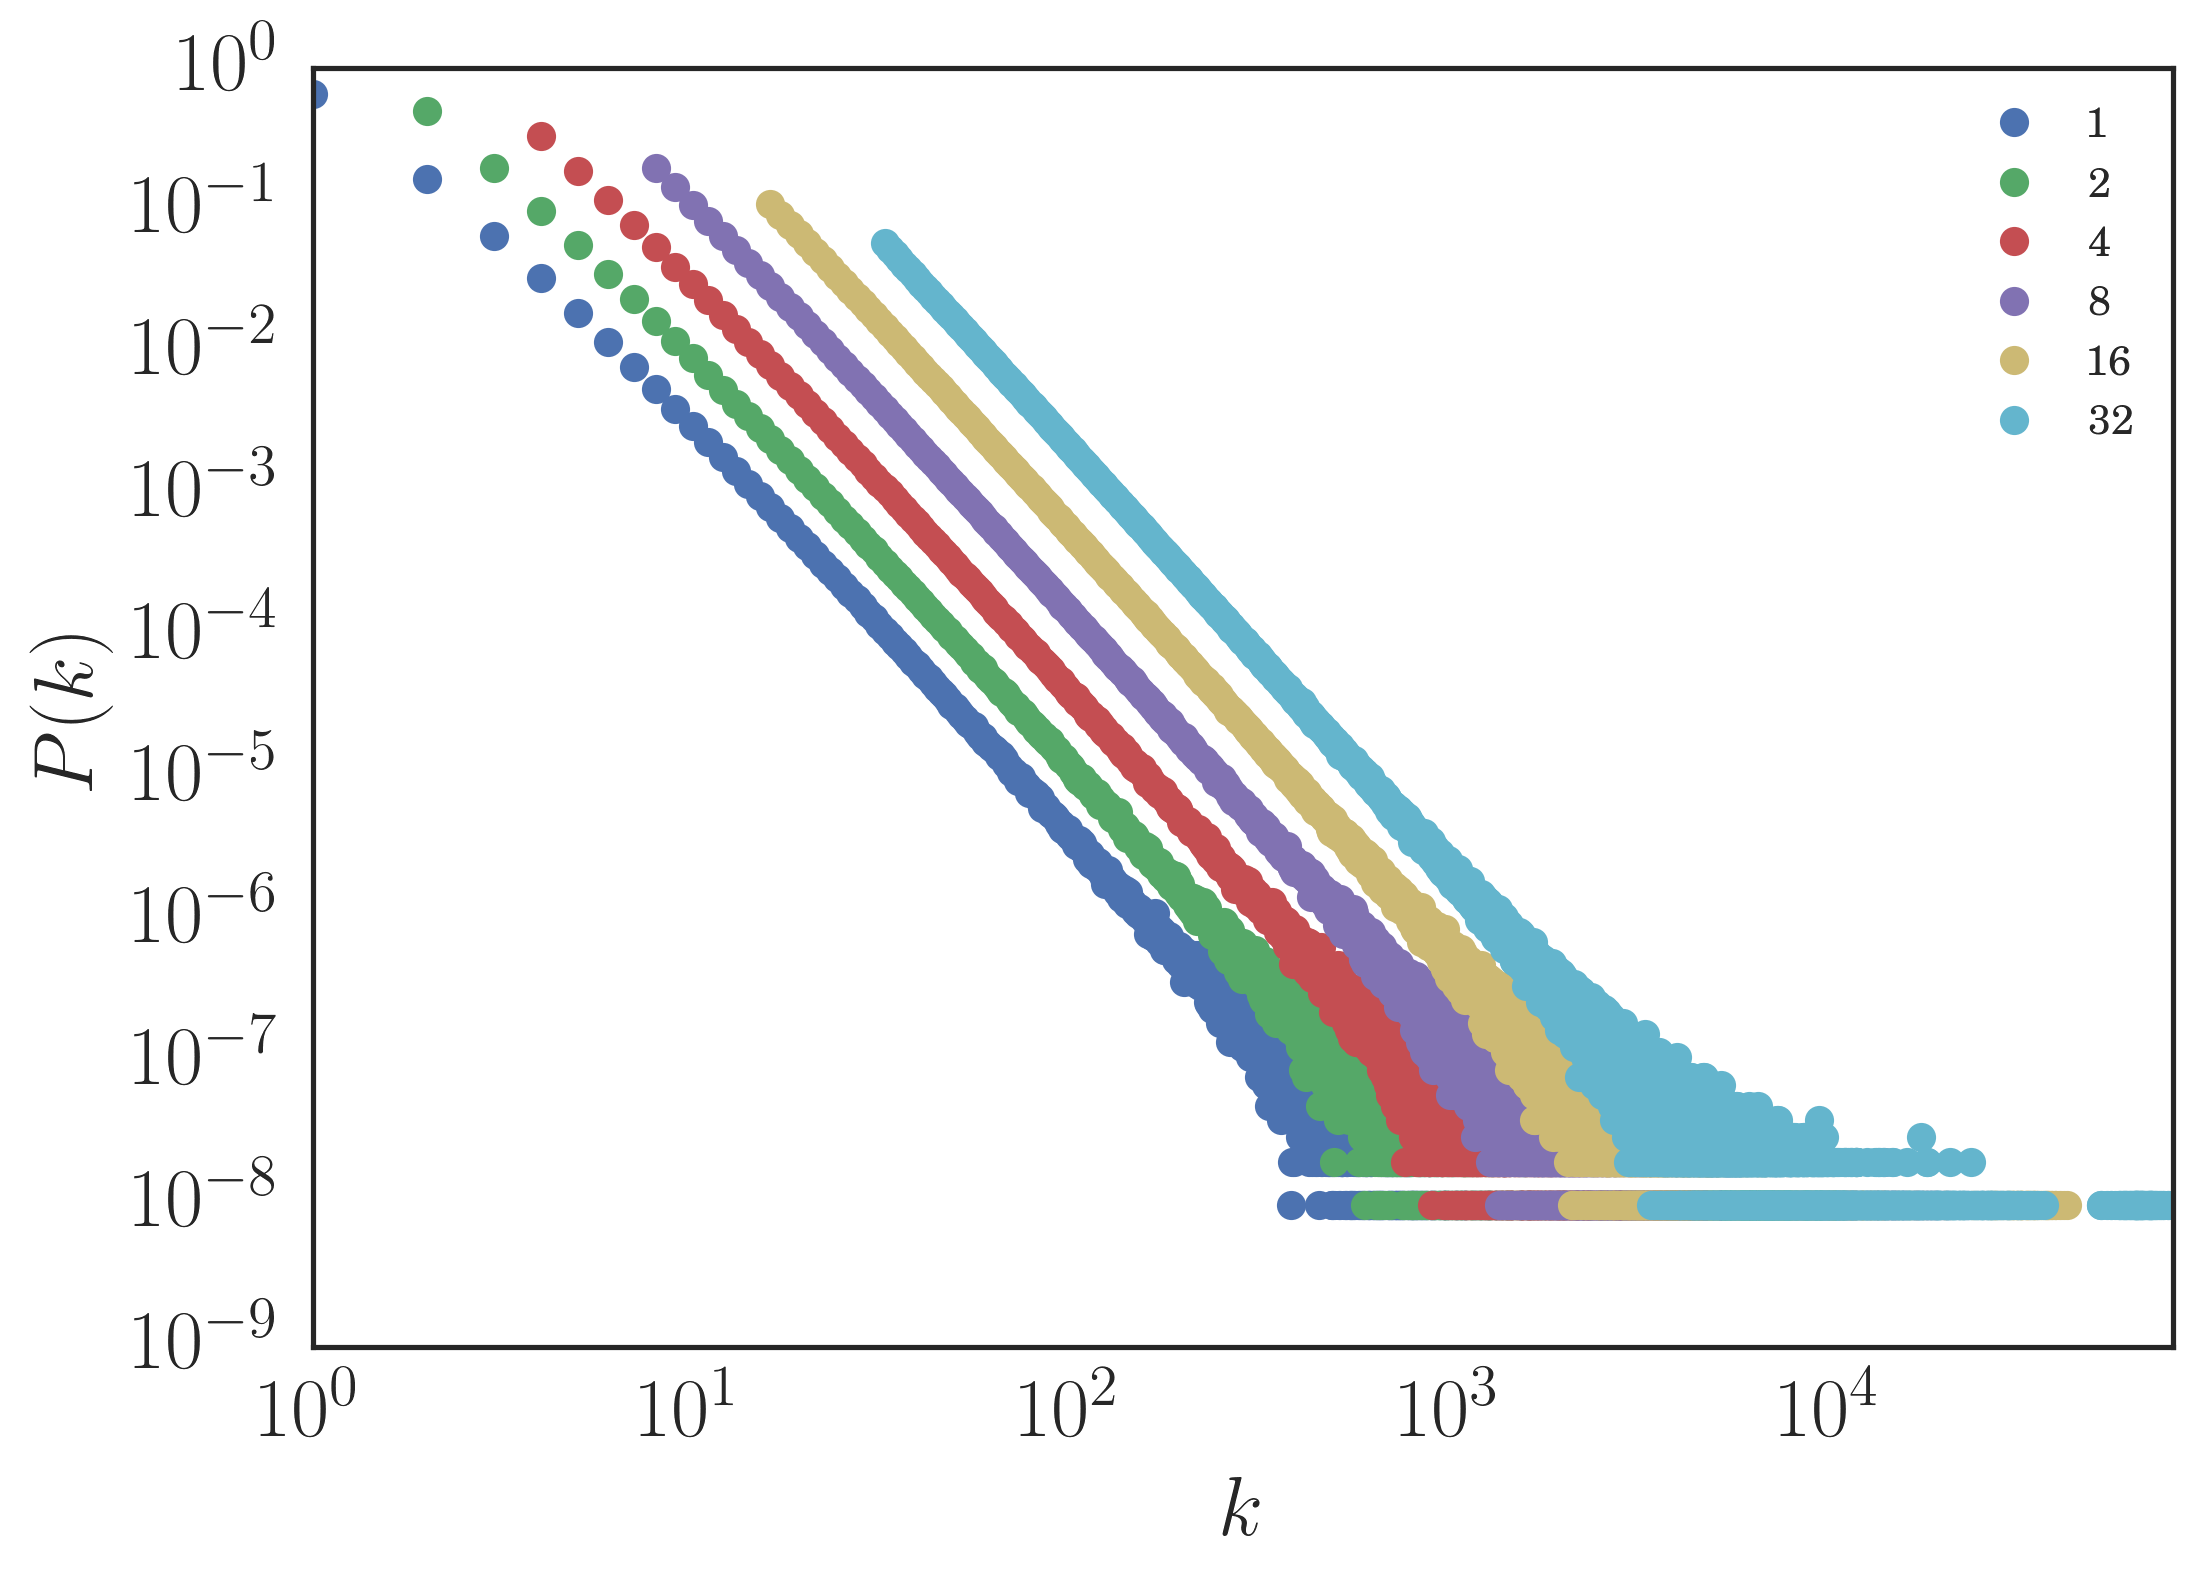

In [5]:
fixed_n_degrees.plot(style='o', loglog=True, fontsize=font_size, ylim=(1e-9, 1))
ax = plt.gca()
ax.set_ylabel(u'$P(k)$', fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)

## Visualizing ccdf

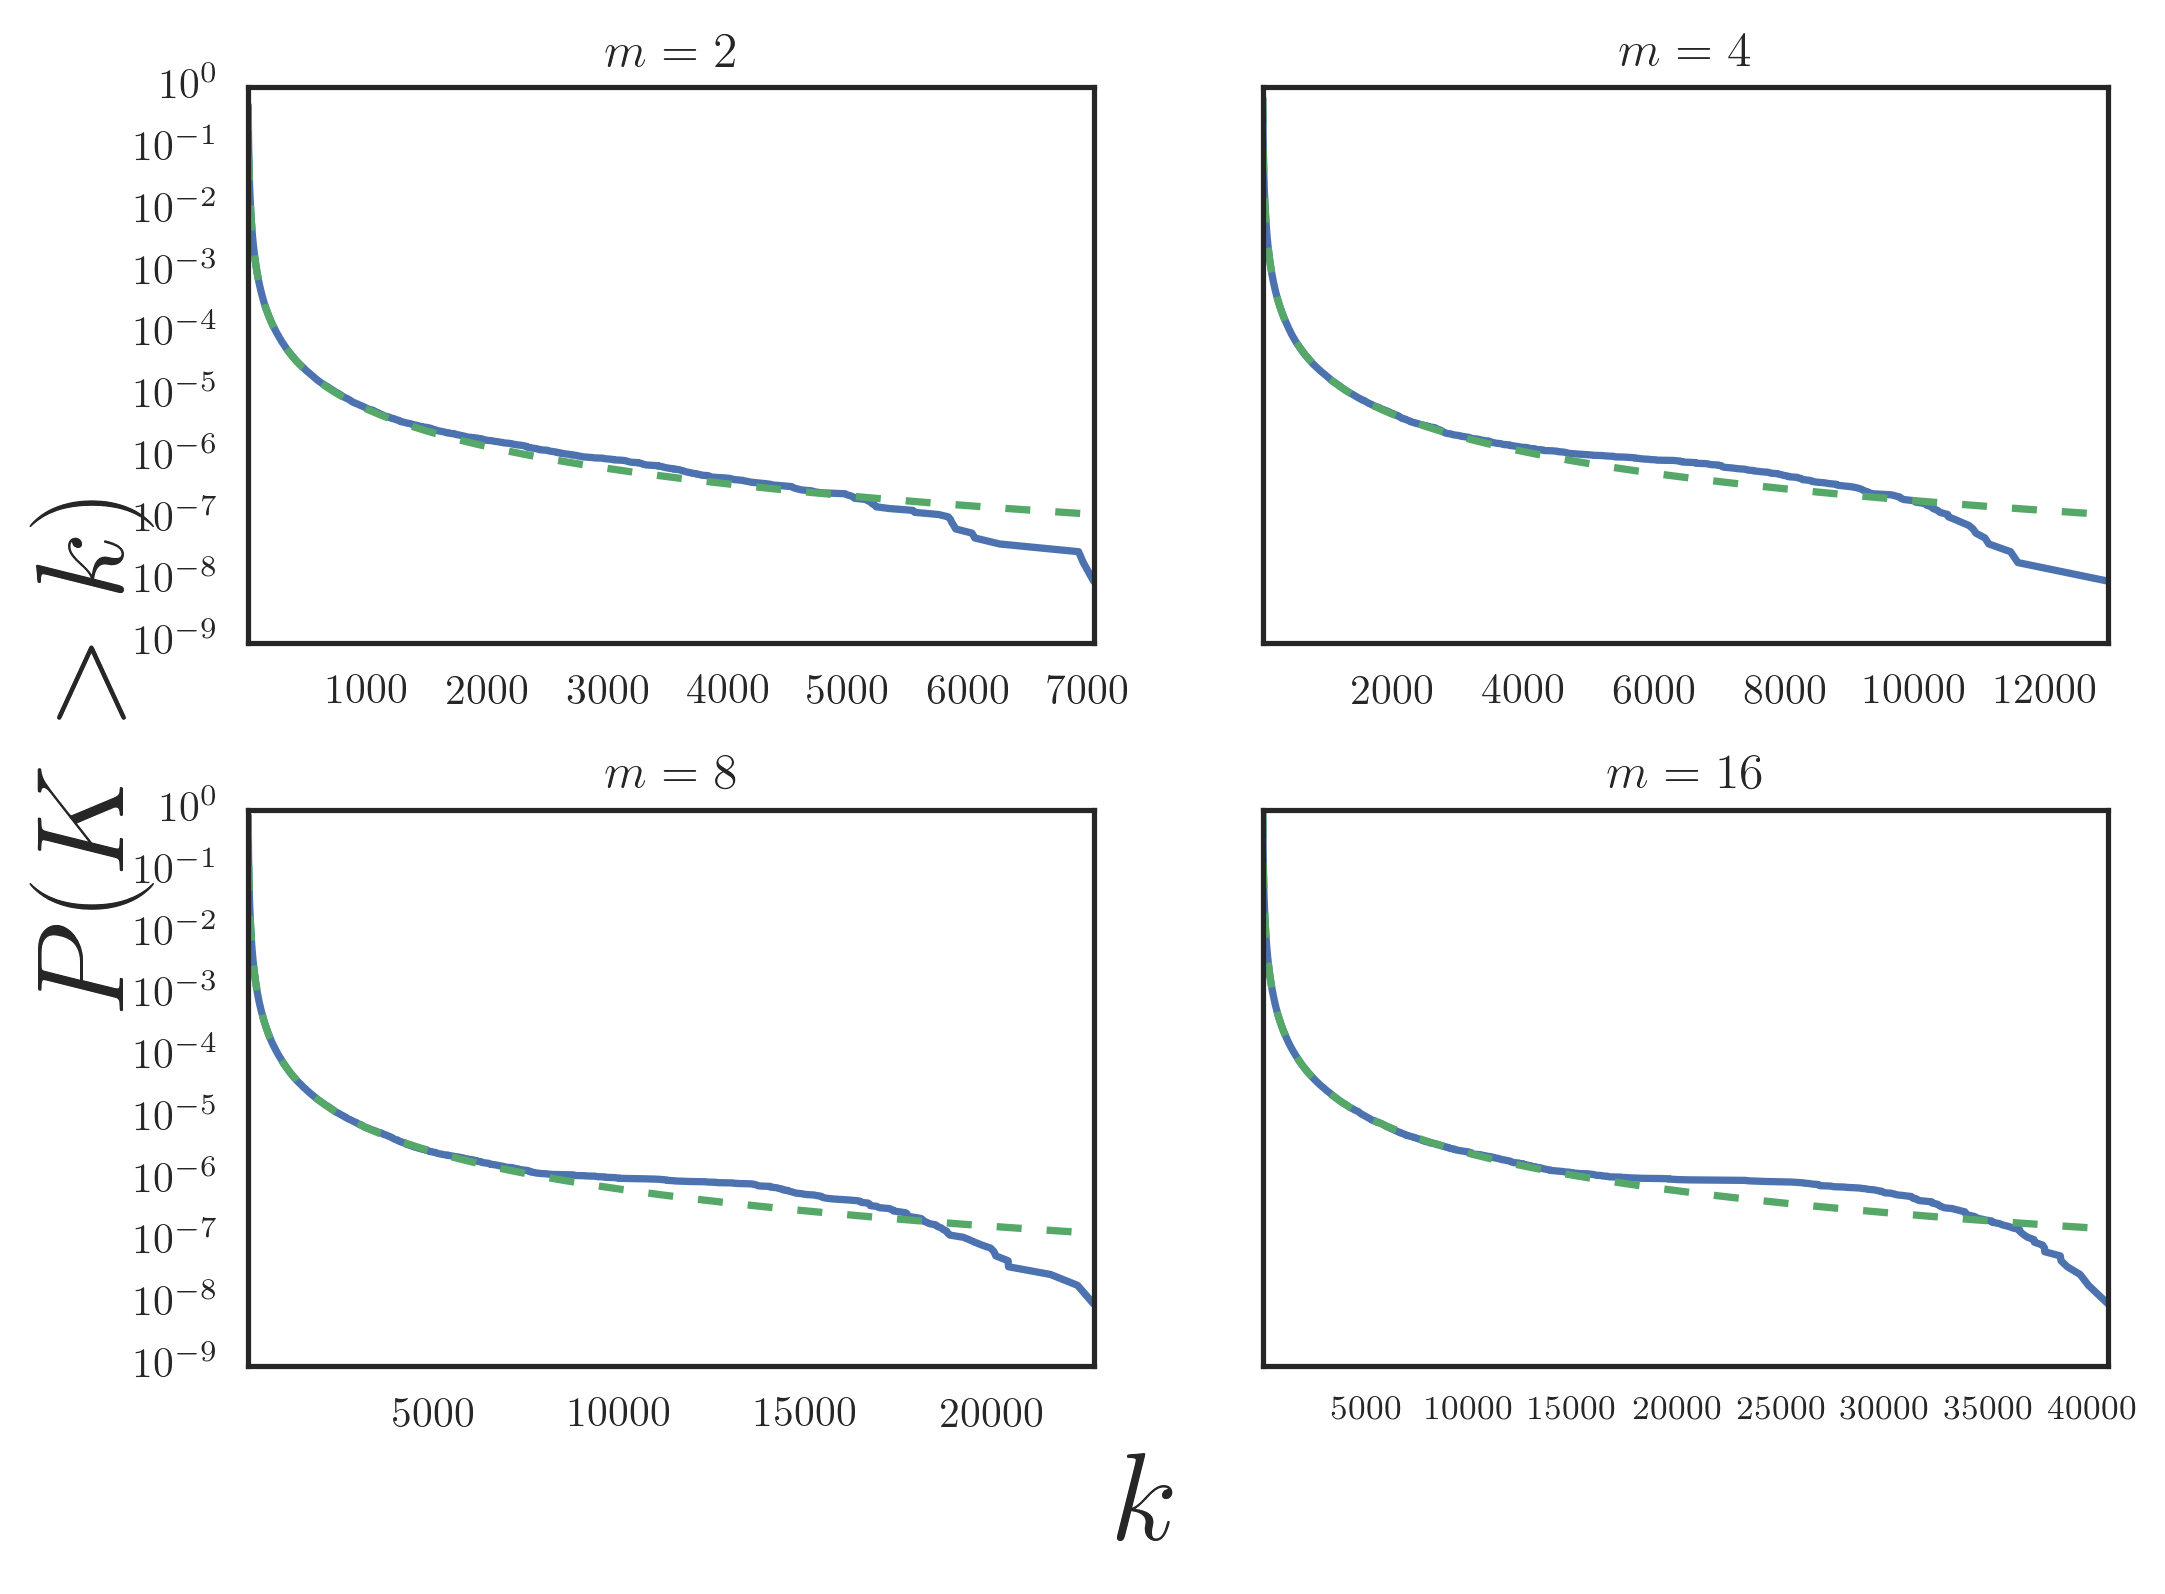

In [6]:
# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='row')
utils.visualize_ccdf(fixed_n_degrees, 2, font_size=10, ax=ax1)
ax1.set_title(u'$m=2$')
utils.visualize_ccdf(fixed_n_degrees, 4, font_size=10, ax=ax2)
ax2.set_title(u'$m=4$')
utils.visualize_ccdf(fixed_n_degrees, 8, font_size=10, ax=ax3)
ax3.set_title(u'$m=8$')
utils.visualize_ccdf(fixed_n_degrees, 16, font_size=8, ax=ax4)
ax4.set_title(u'$m=16$')
plt.gcf().text(0.5, 0.04, u'$k$', ha='center', va='center')
plt.gcf().text(0.06, 0.5, u'$P(K>k)$', ha='center', va='center', rotation='vertical')
f.subplots_adjust(hspace=0.3)

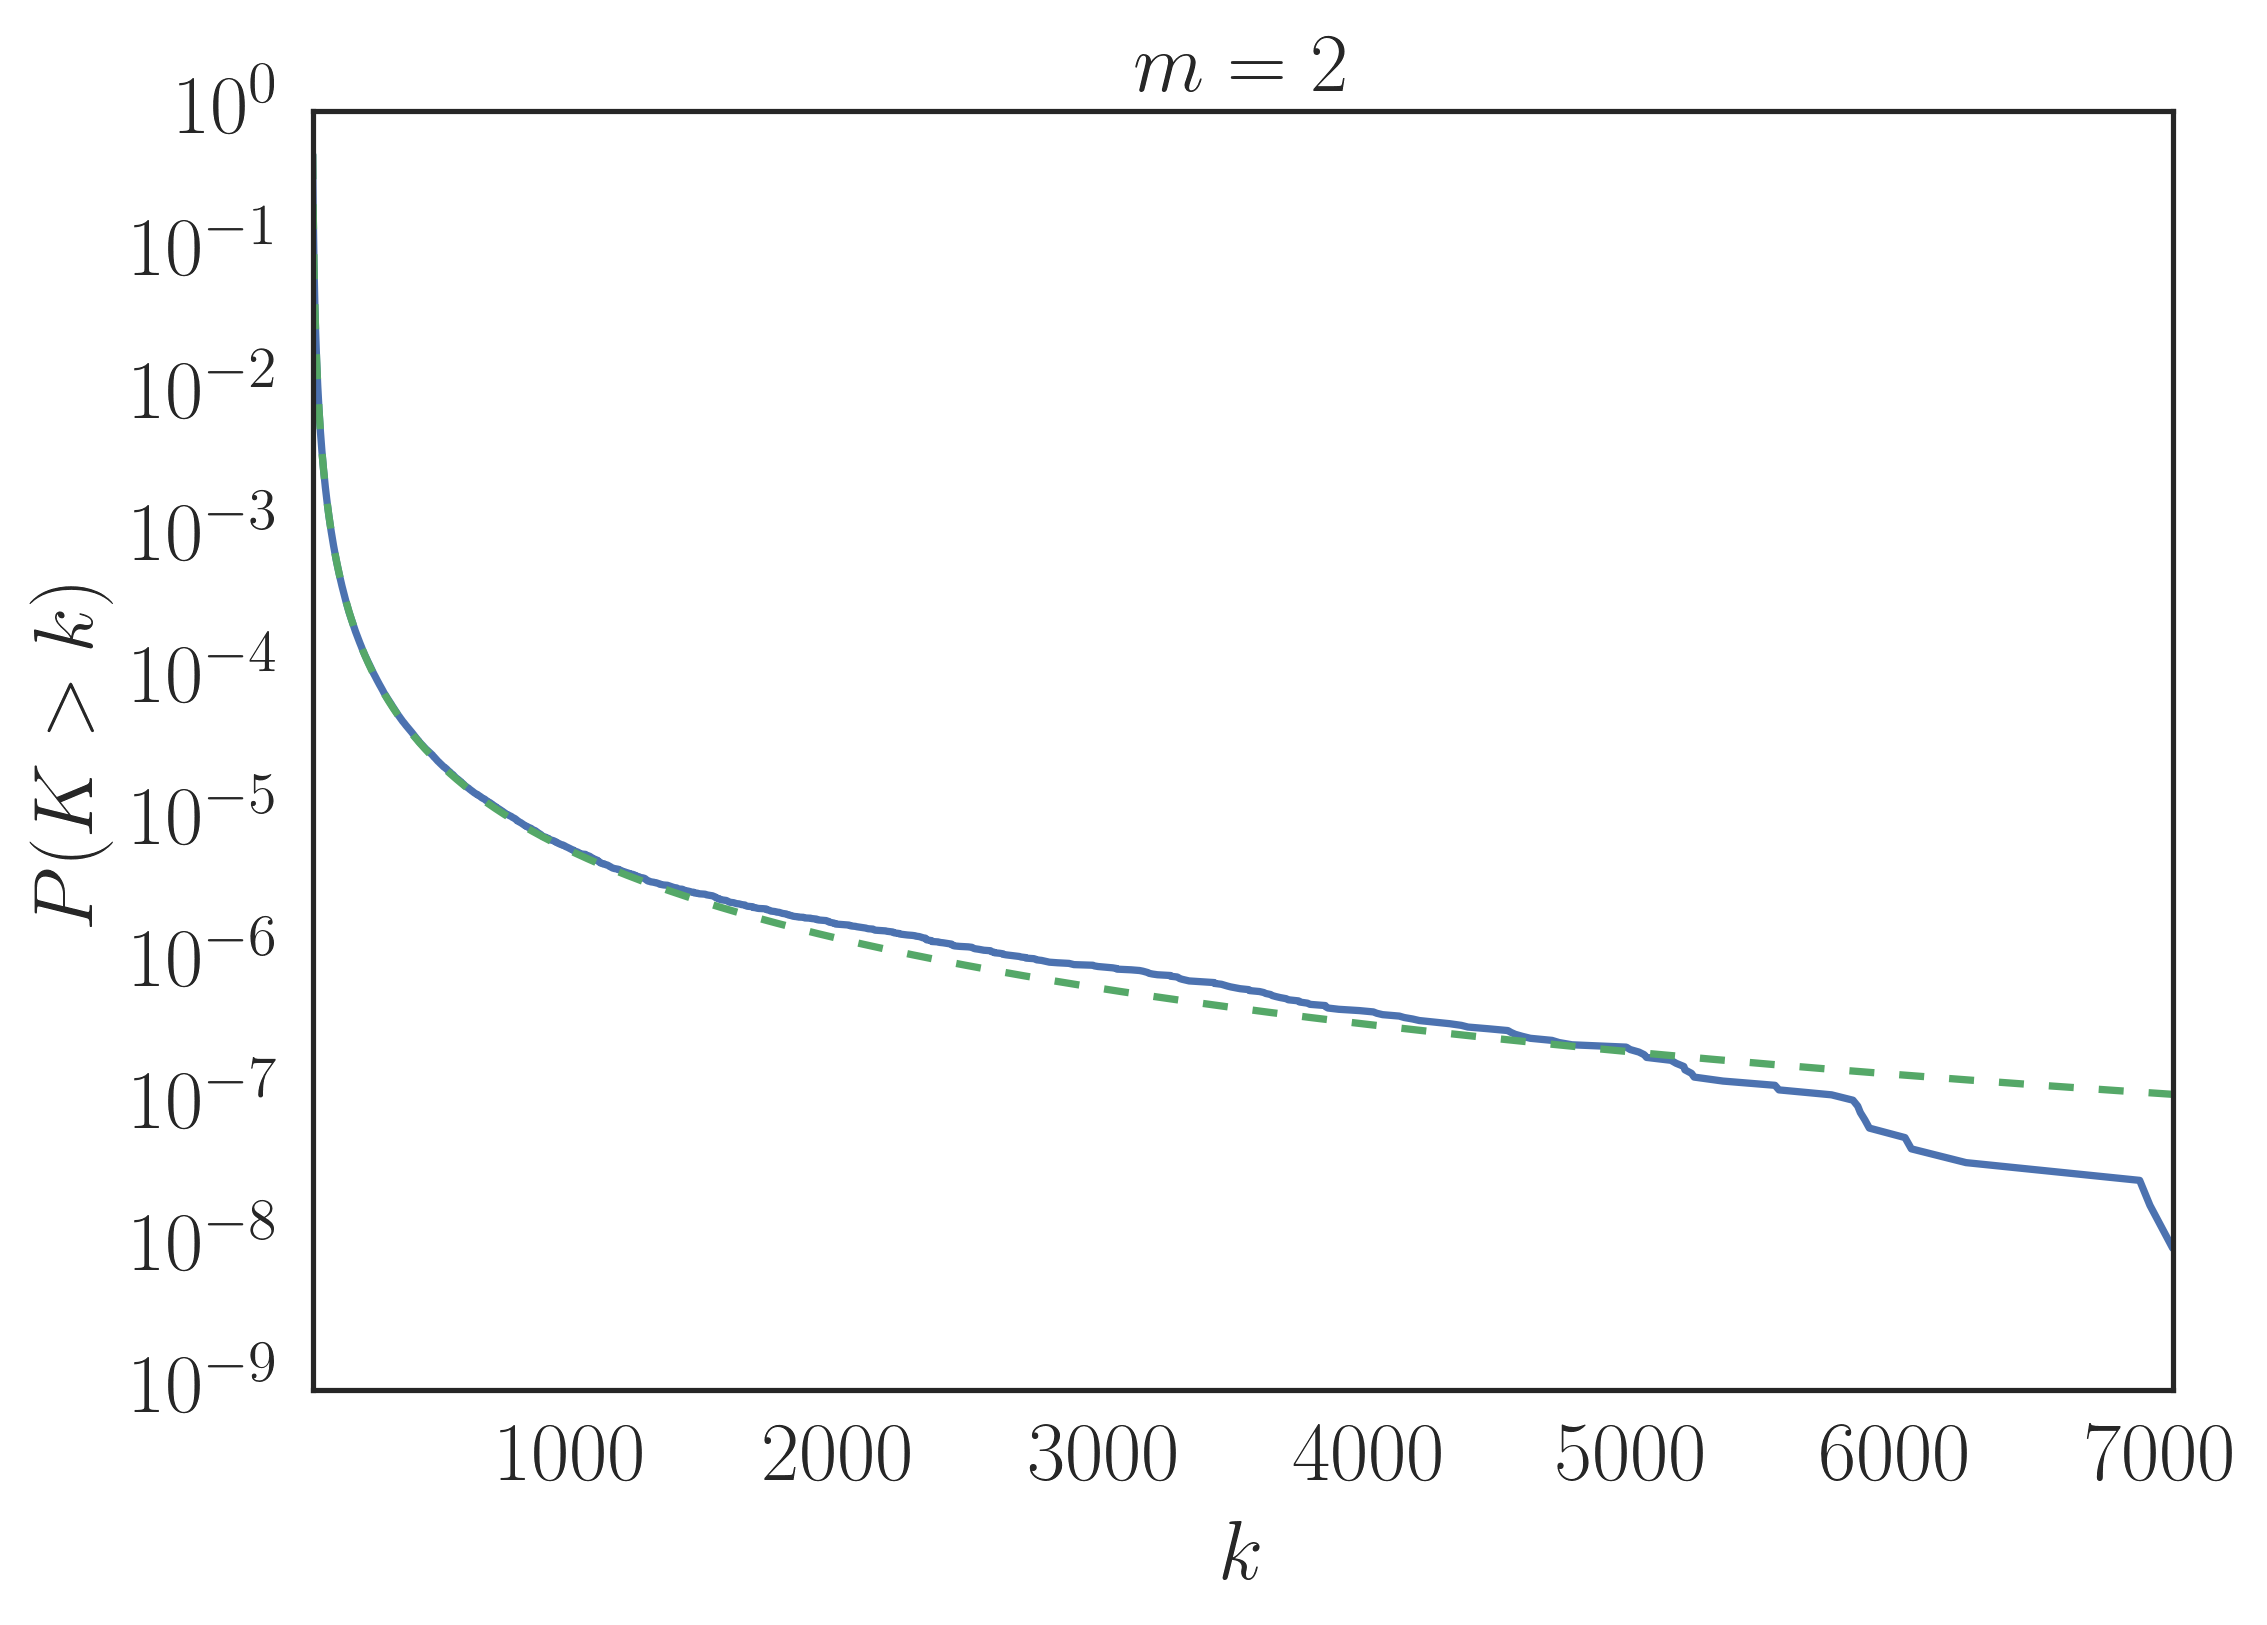

In [7]:
utils.visualize_ccdf(fixed_n_degrees, 2, font_size=font_size)
ax = plt.gca()
ax.set_ylabel(u'$P(K > k)$', fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)
plt.title(u"$m = 2$", fontsize=font_size)

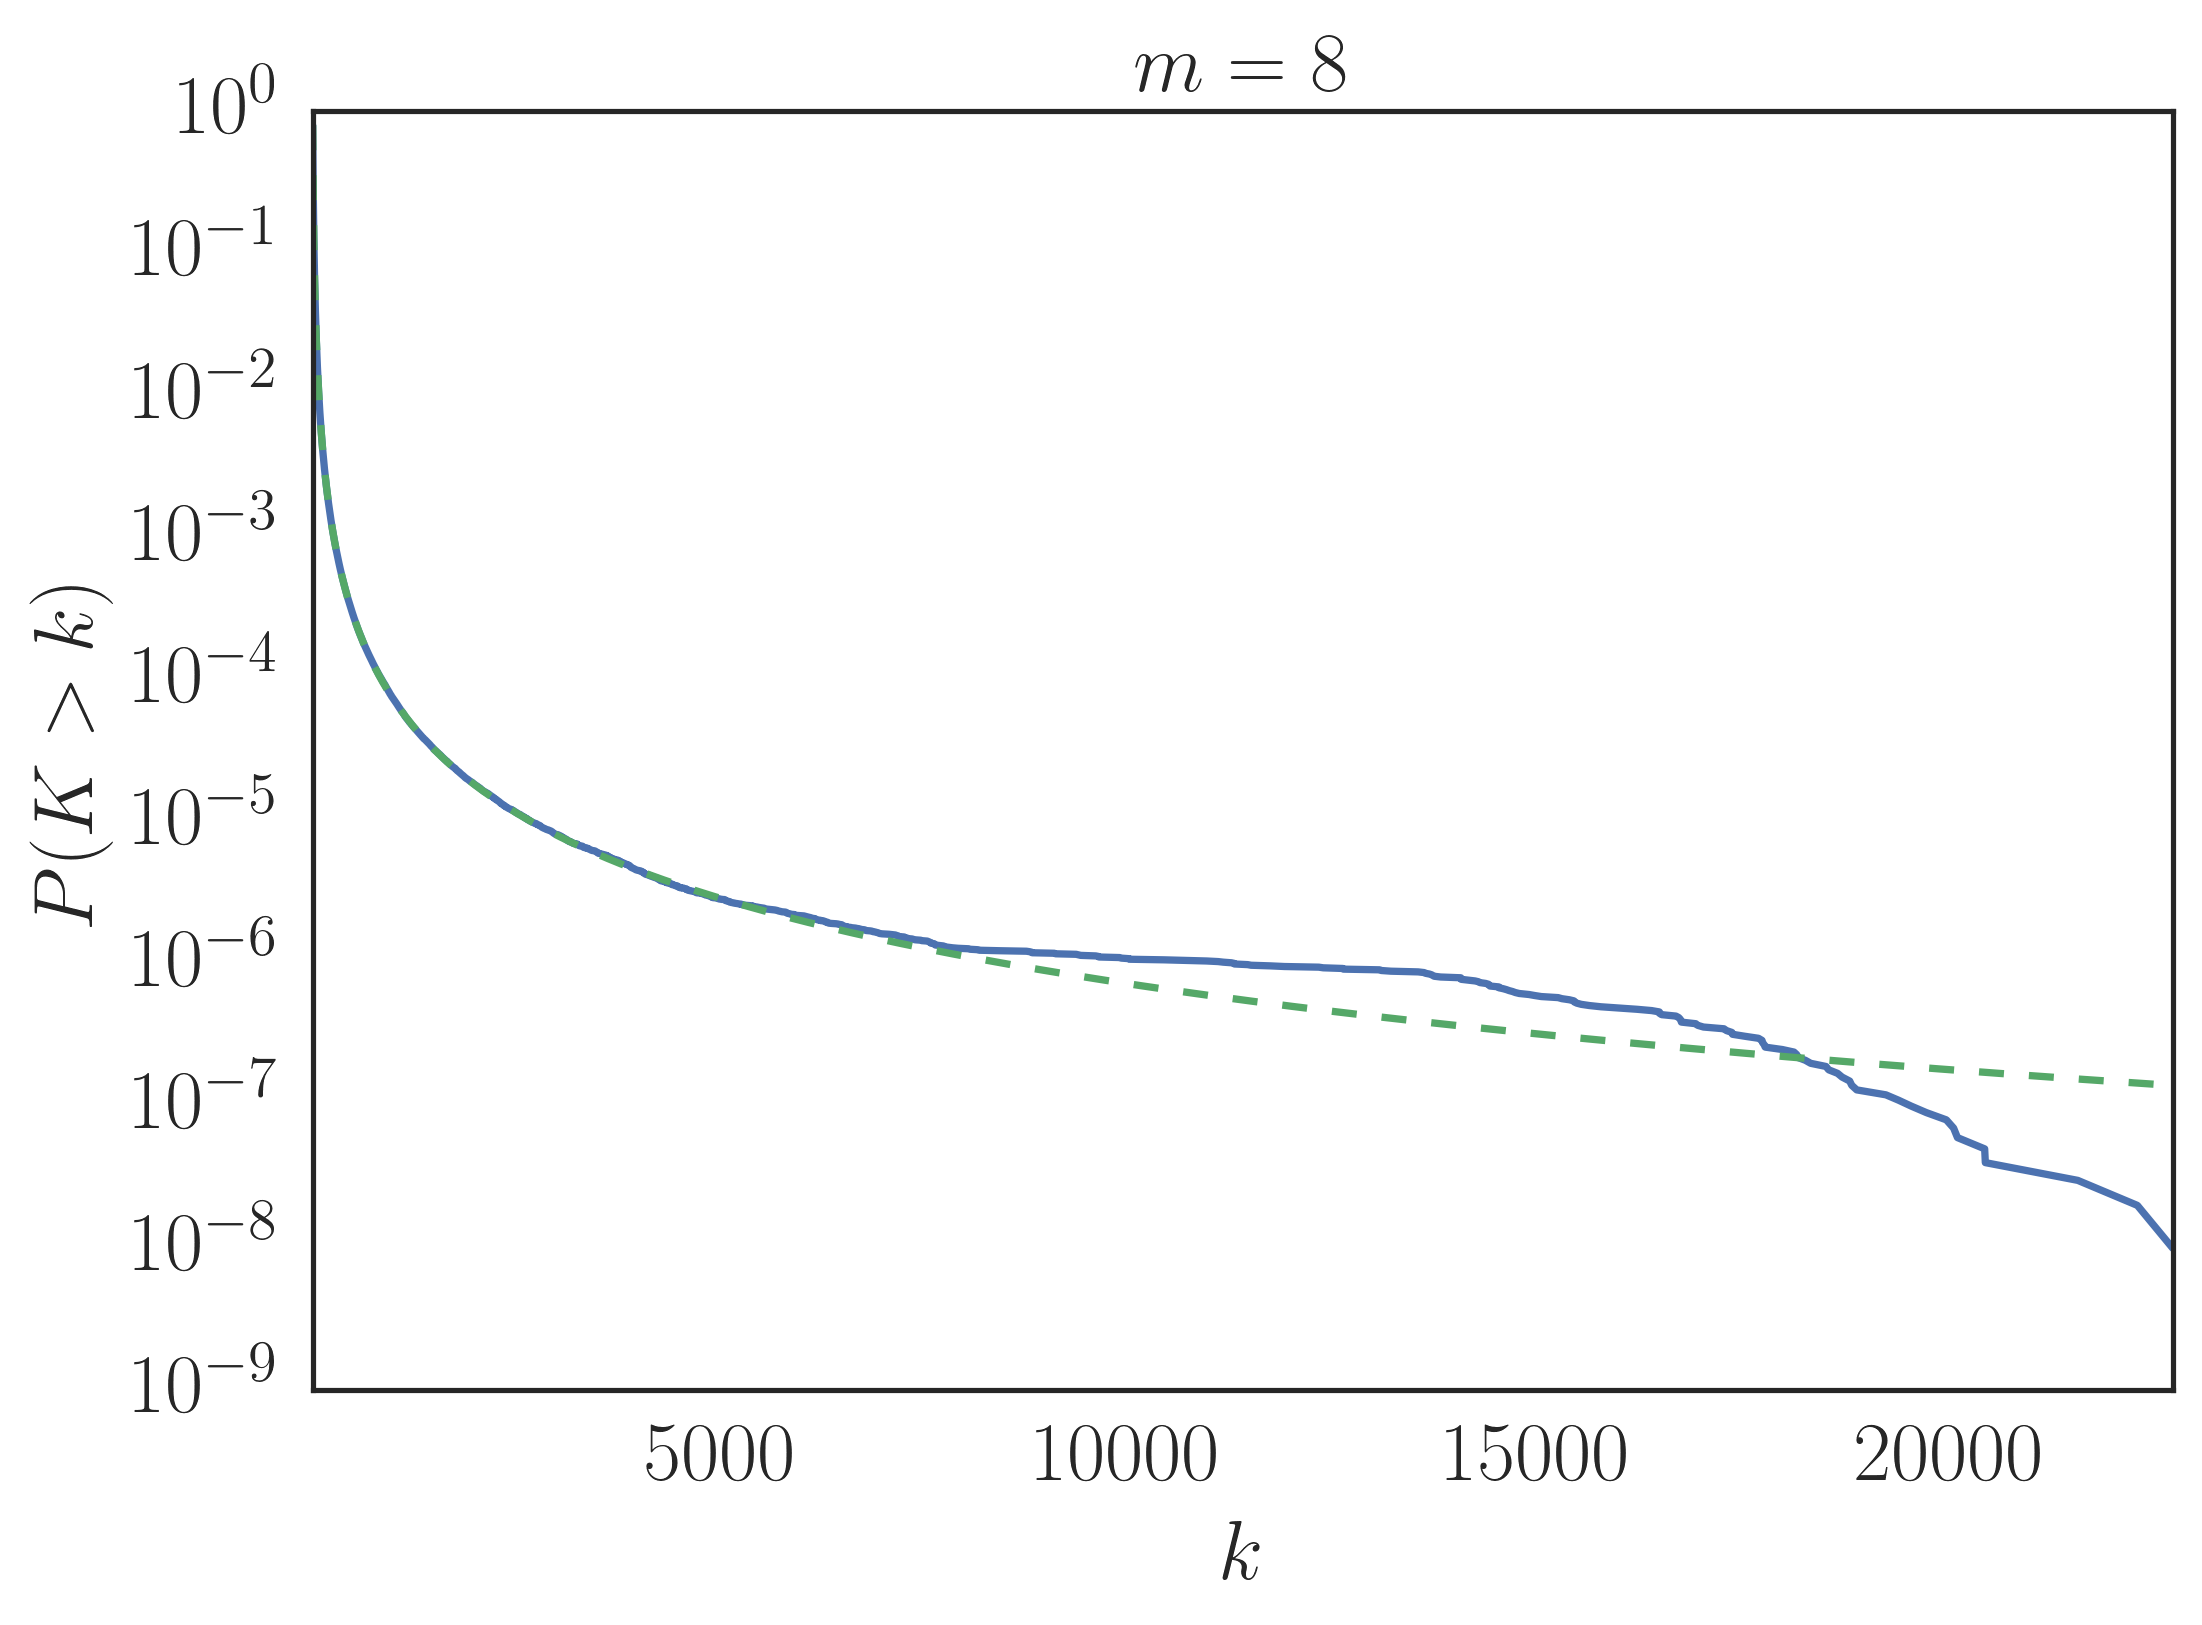

In [8]:
utils.visualize_ccdf(fixed_n_degrees, 8, font_size=font_size)
ax = plt.gca()
ax.set_ylabel(u'$P(K > k)$', fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)
plt.title(u"$m = 8$", fontsize=font_size)

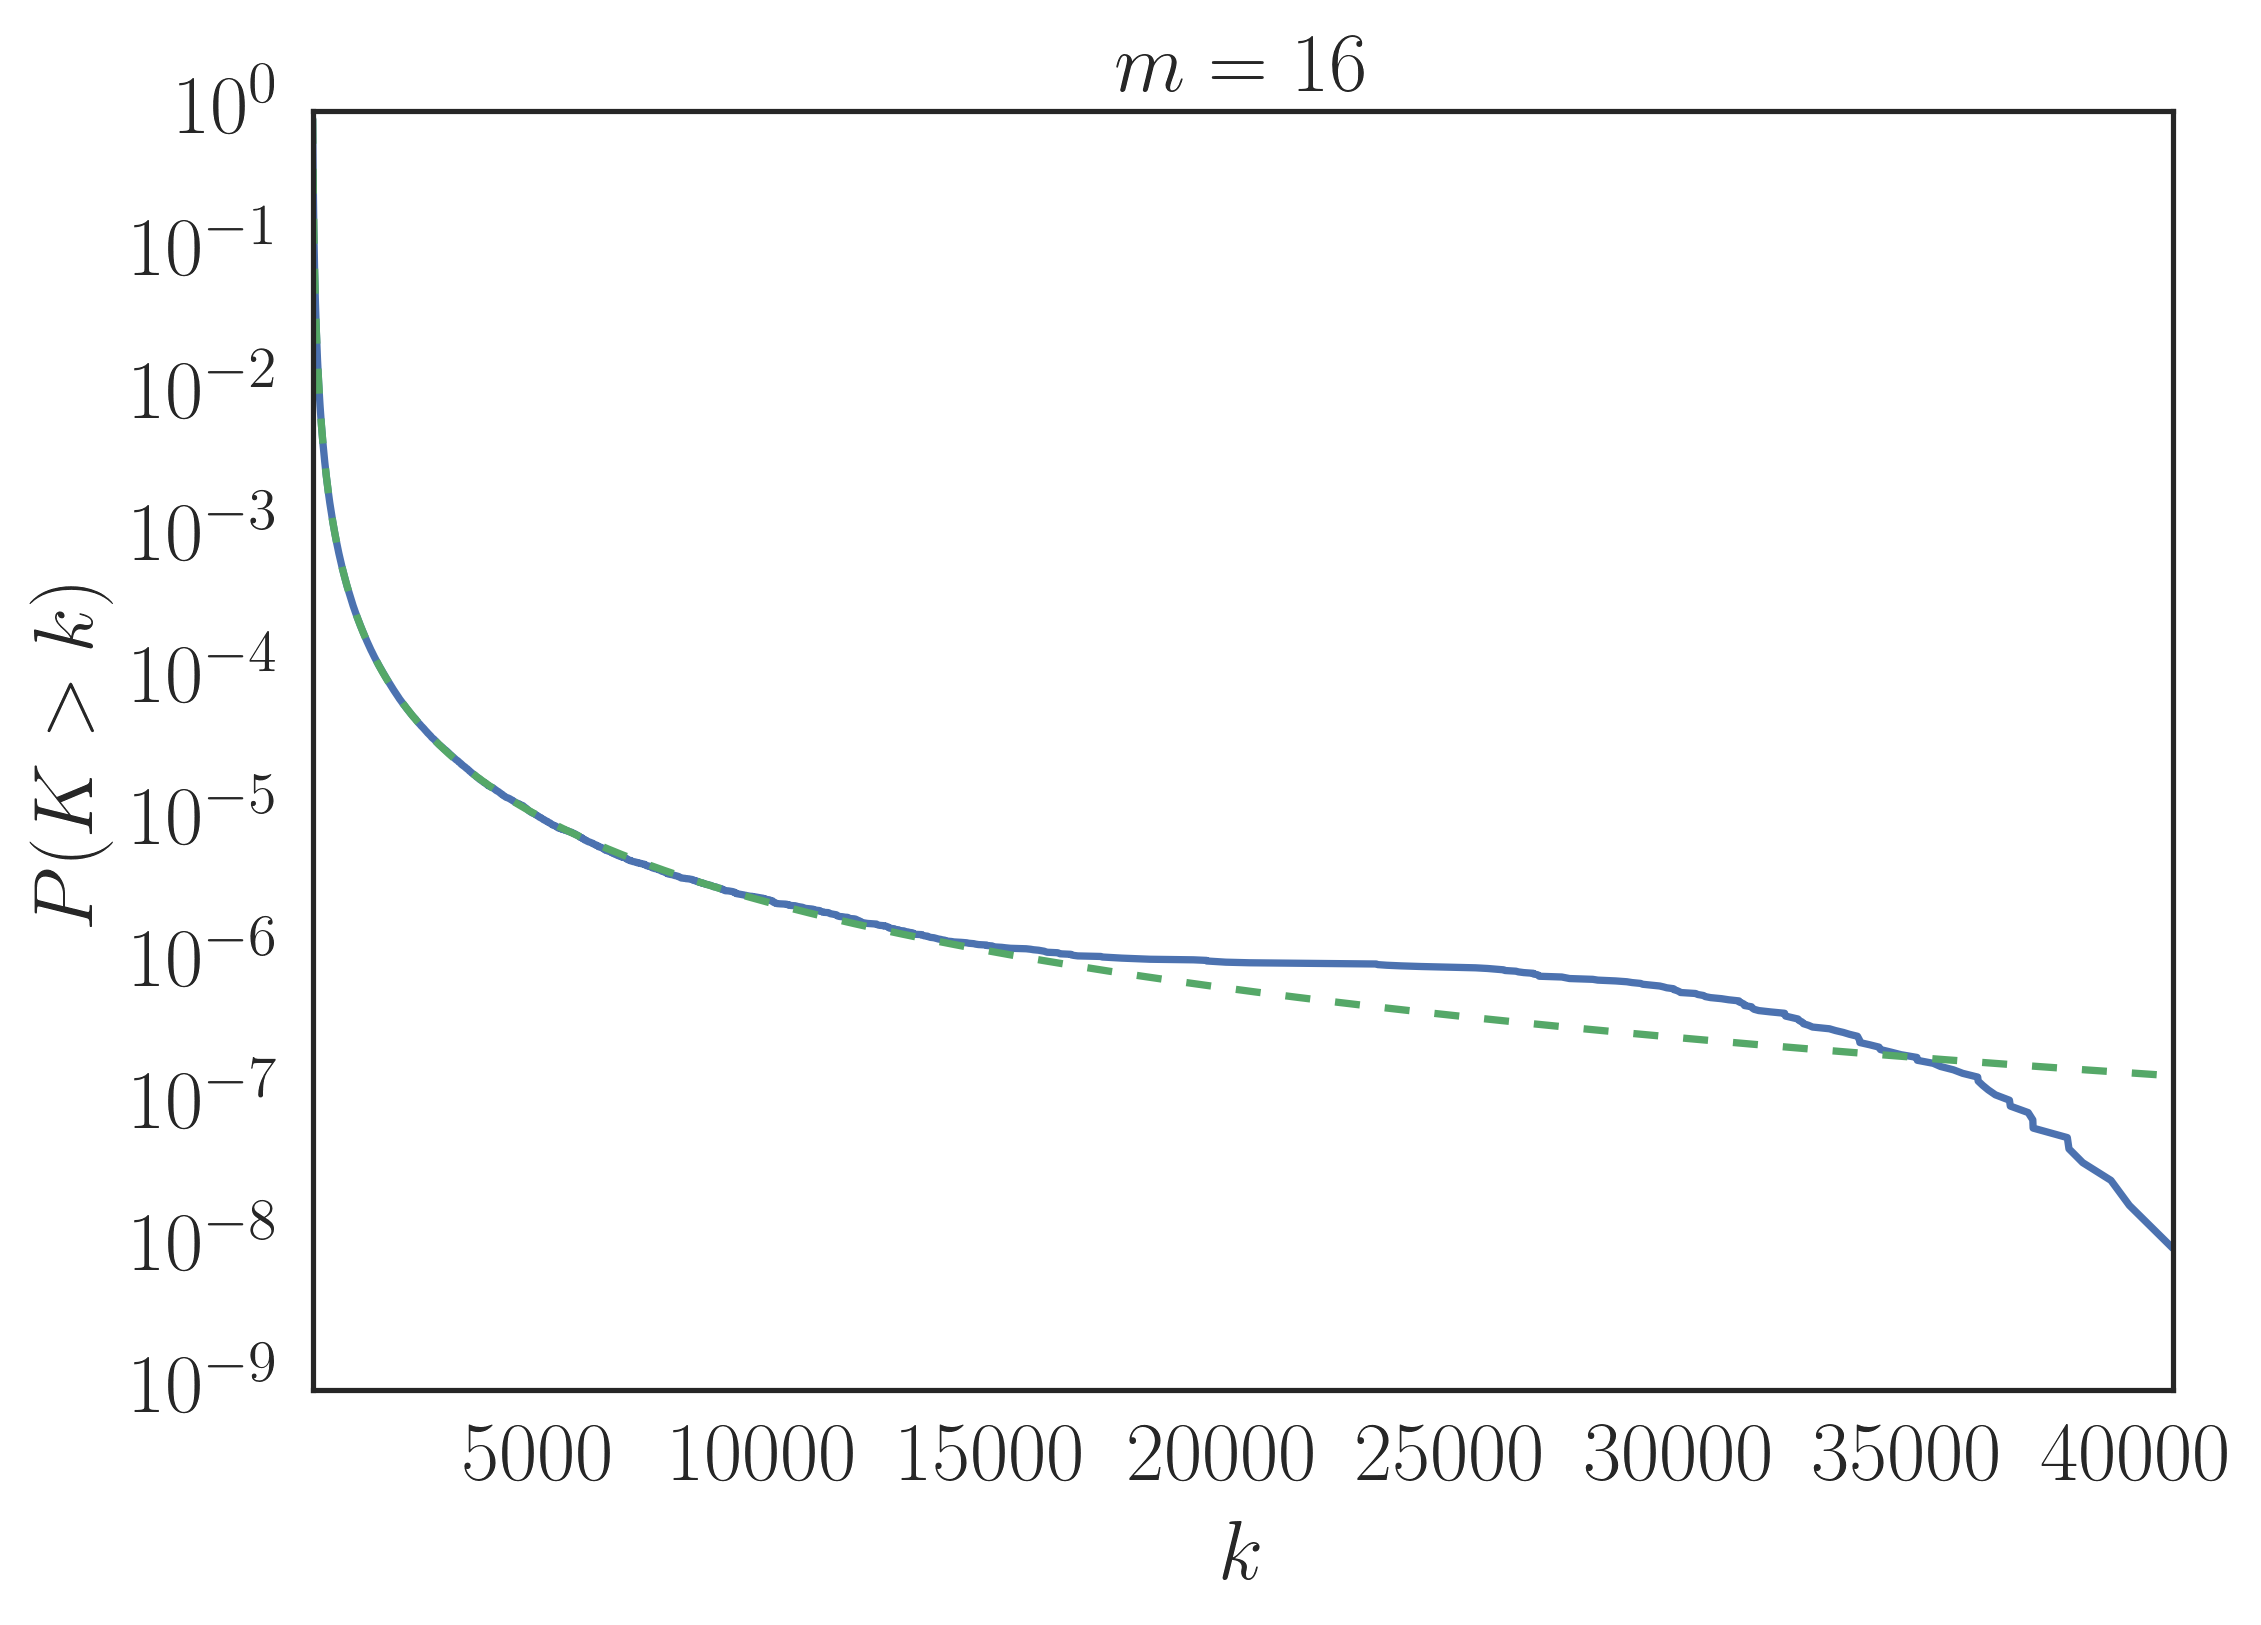

In [9]:
utils.visualize_ccdf(fixed_n_degrees, 16, font_size=font_size)
ax = plt.gca()
ax.set_ylabel(u'$P(K > k)$', fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)
plt.title(u"$m = 16$", fontsize=font_size)

## log bin

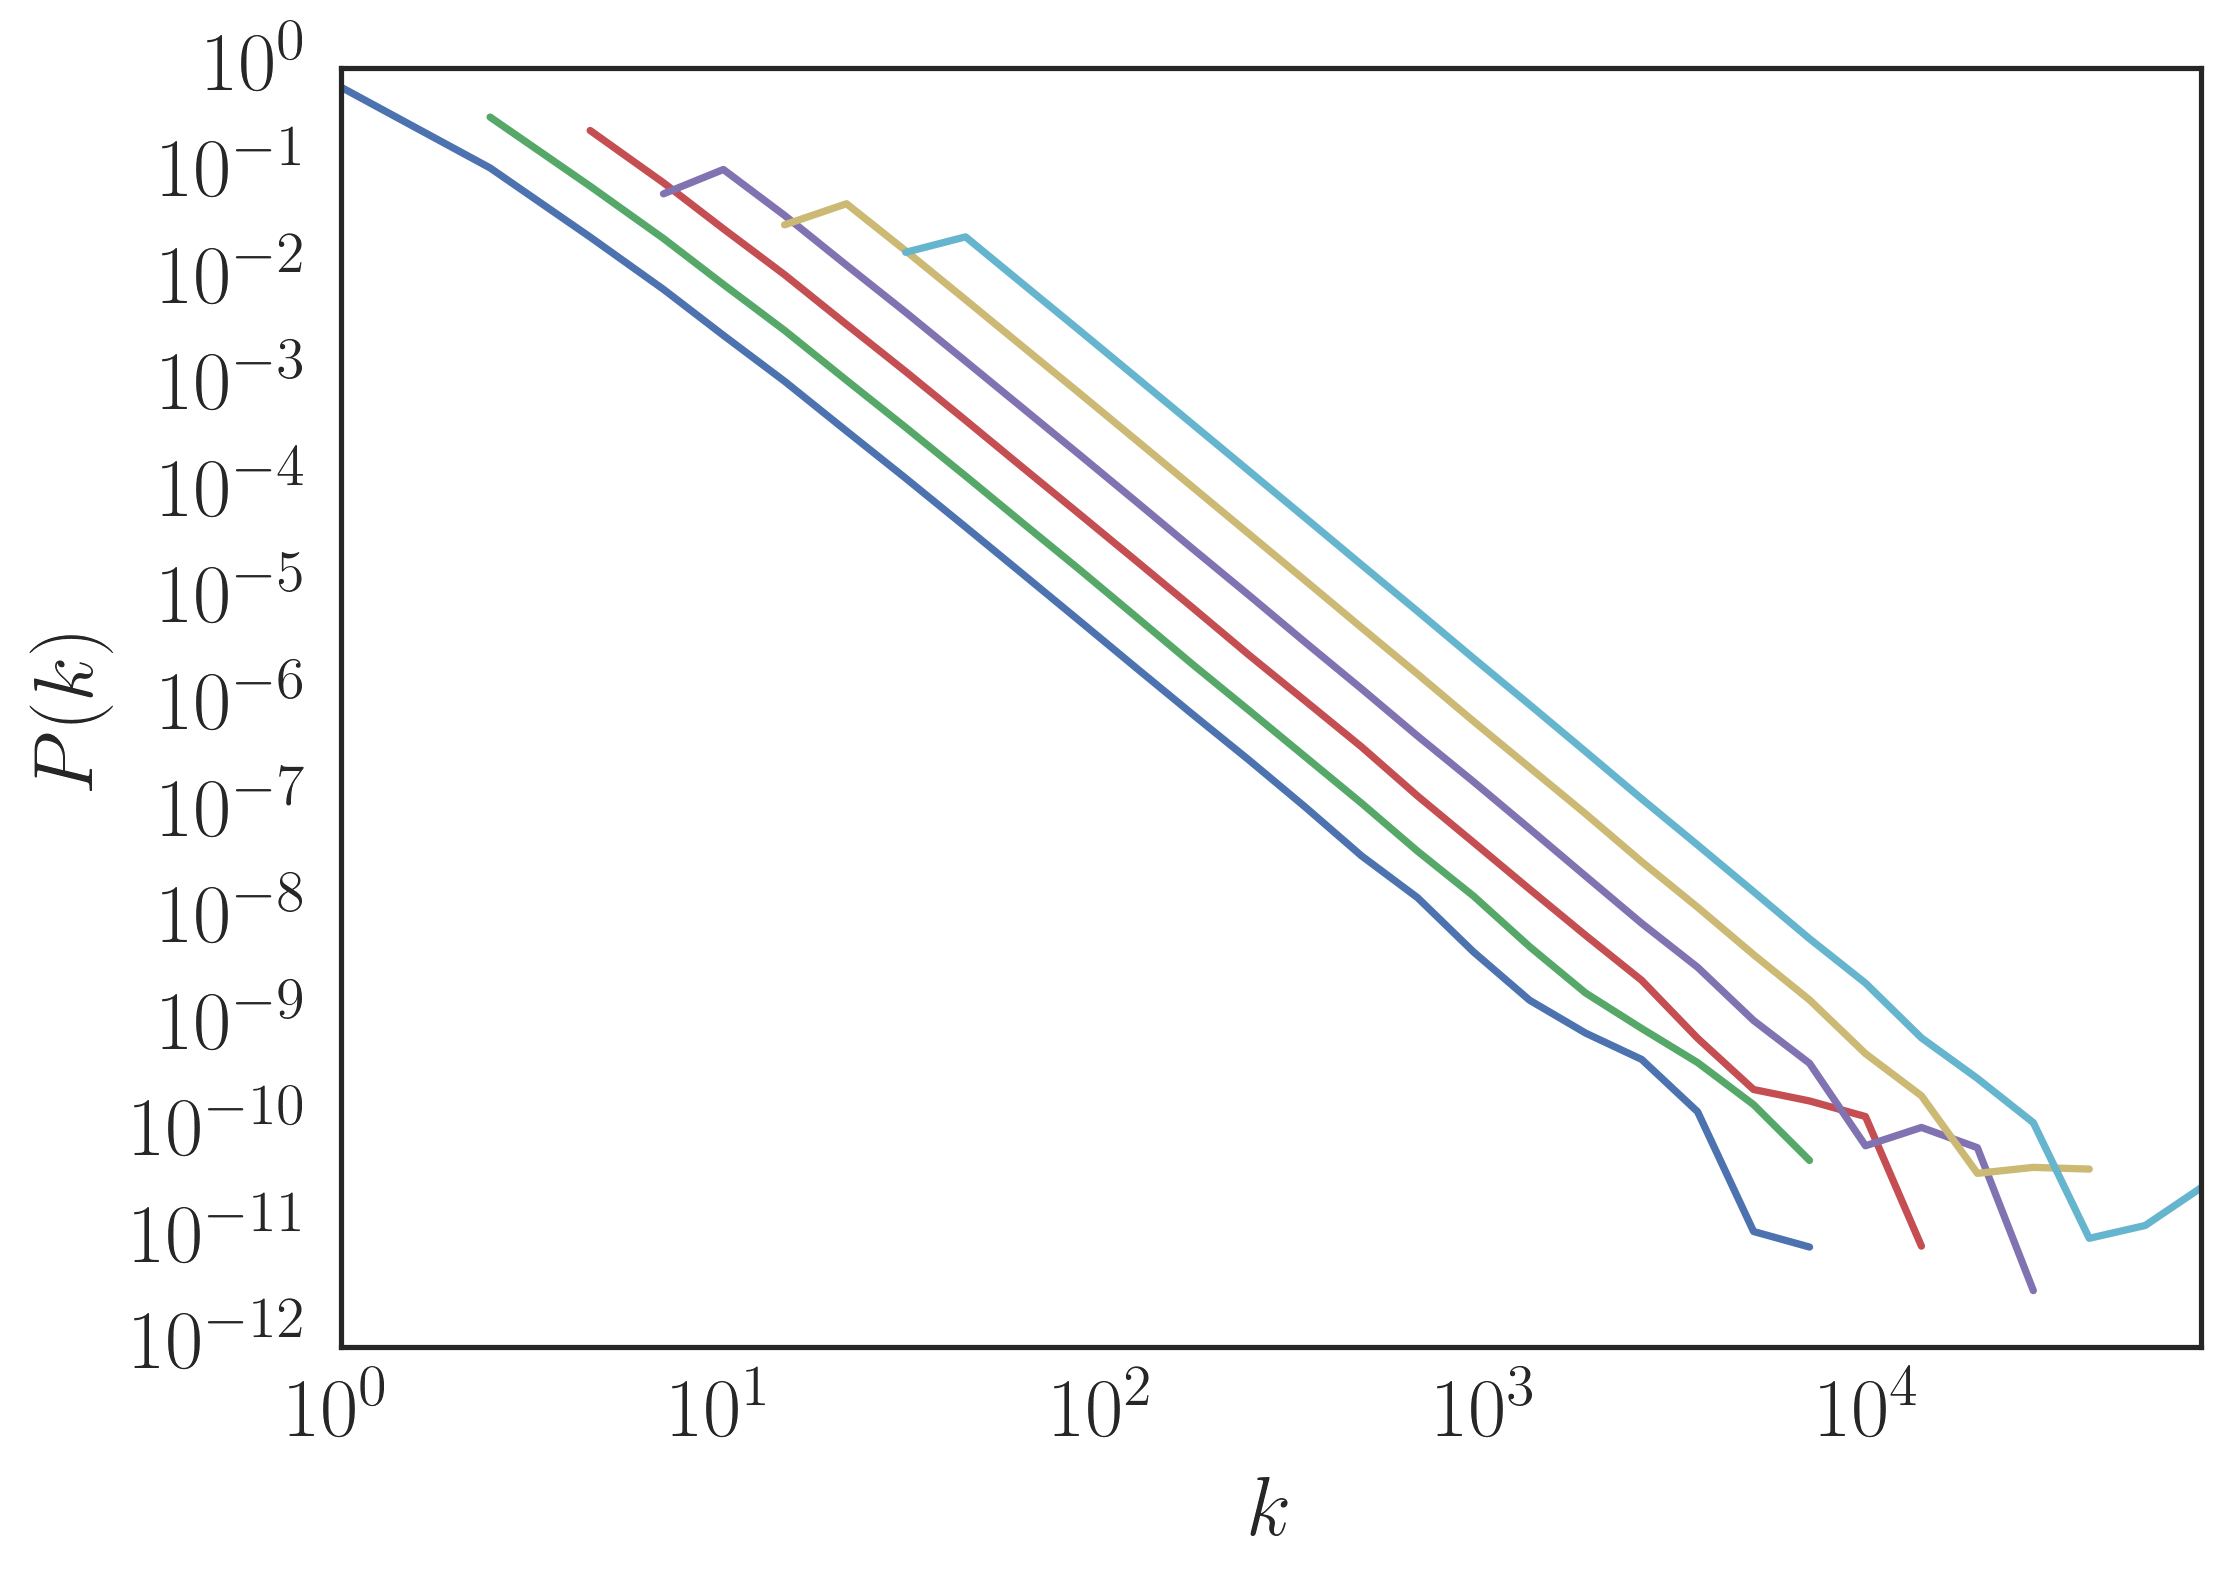

In [10]:
fixed_n_logbin = utils.log_bin_freq_and_plot(fixed_n_degrees, a=1.4, font_size=font_size, style='-', loglog=True)

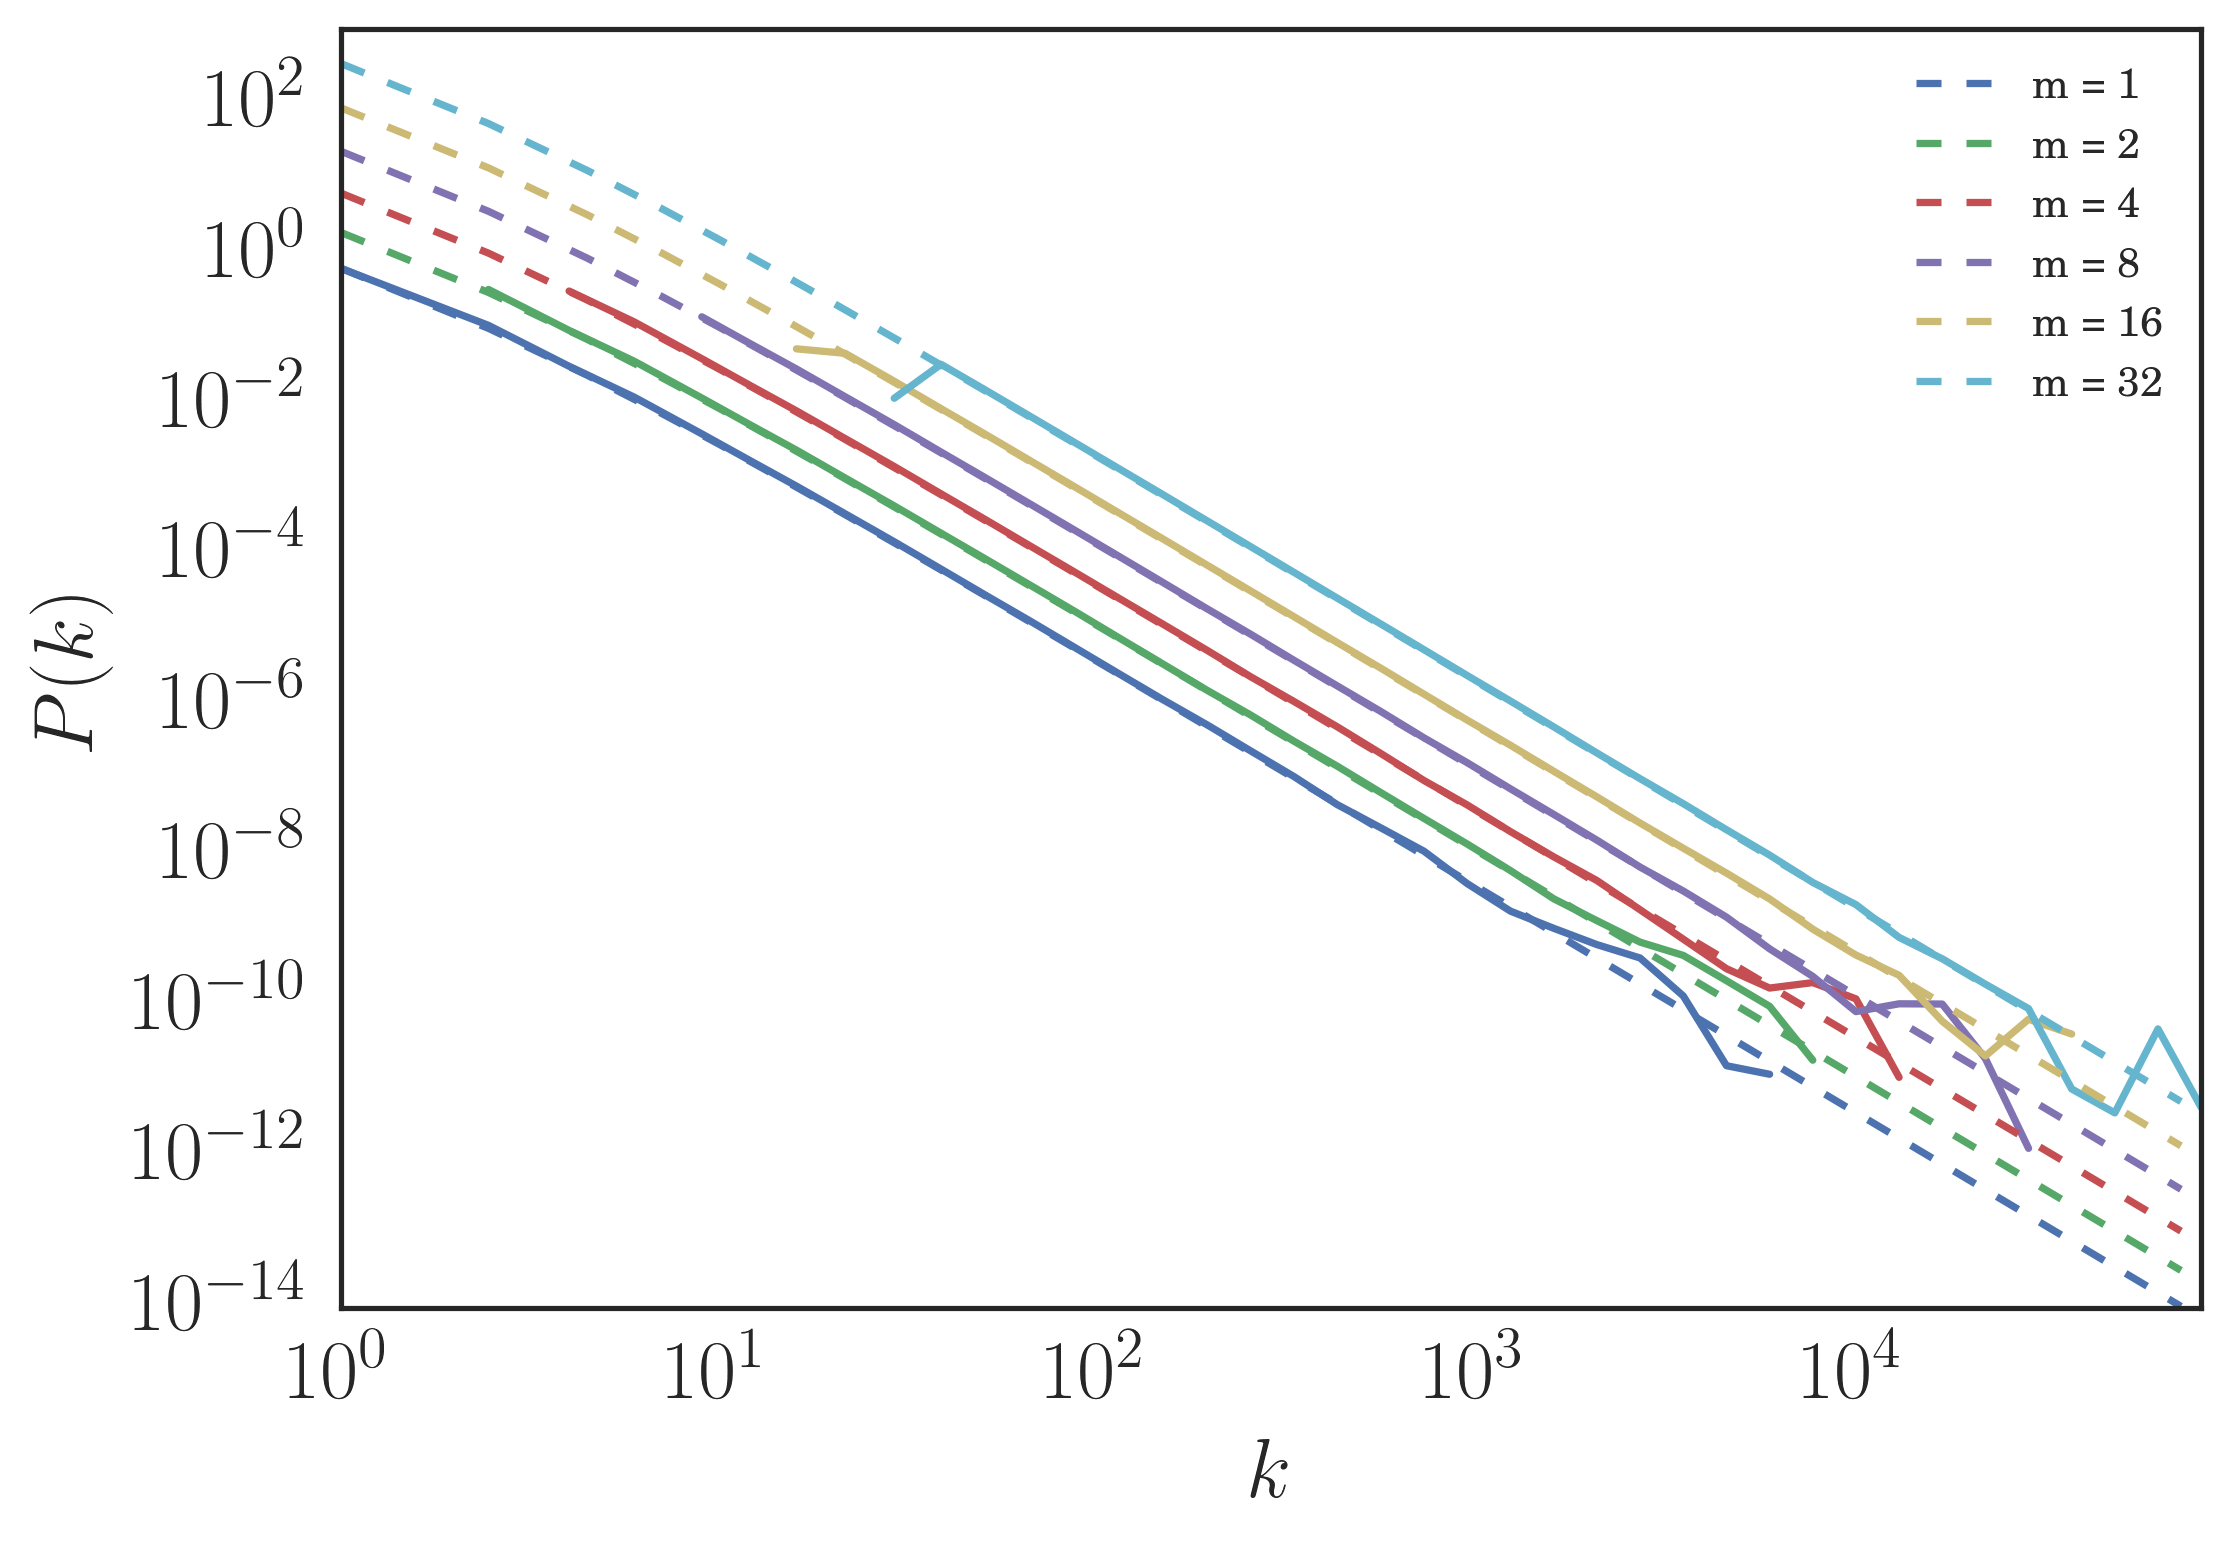

In [11]:
# plot numerical results
utils.log_bin_freq_and_plot(fixed_n_degrees, a=1.3, font_size=font_size, style='-', loglog=True, label='__nolegend__')
result = utils.get_model_df(fixed_n_logbin, fixed_n_logbin.columns)

# plot model
current_palette = sns.color_palette()
for i, col in enumerate(result):
    result[col].dropna().plot(loglog=True, style='--', color=current_palette[i], label='m = '+str(col))
plt.legend()

## r2

1     0.999769
2     0.010811
4     0.000797
8     0.005077
16    0.006037
32    0.005480
dtype: float64

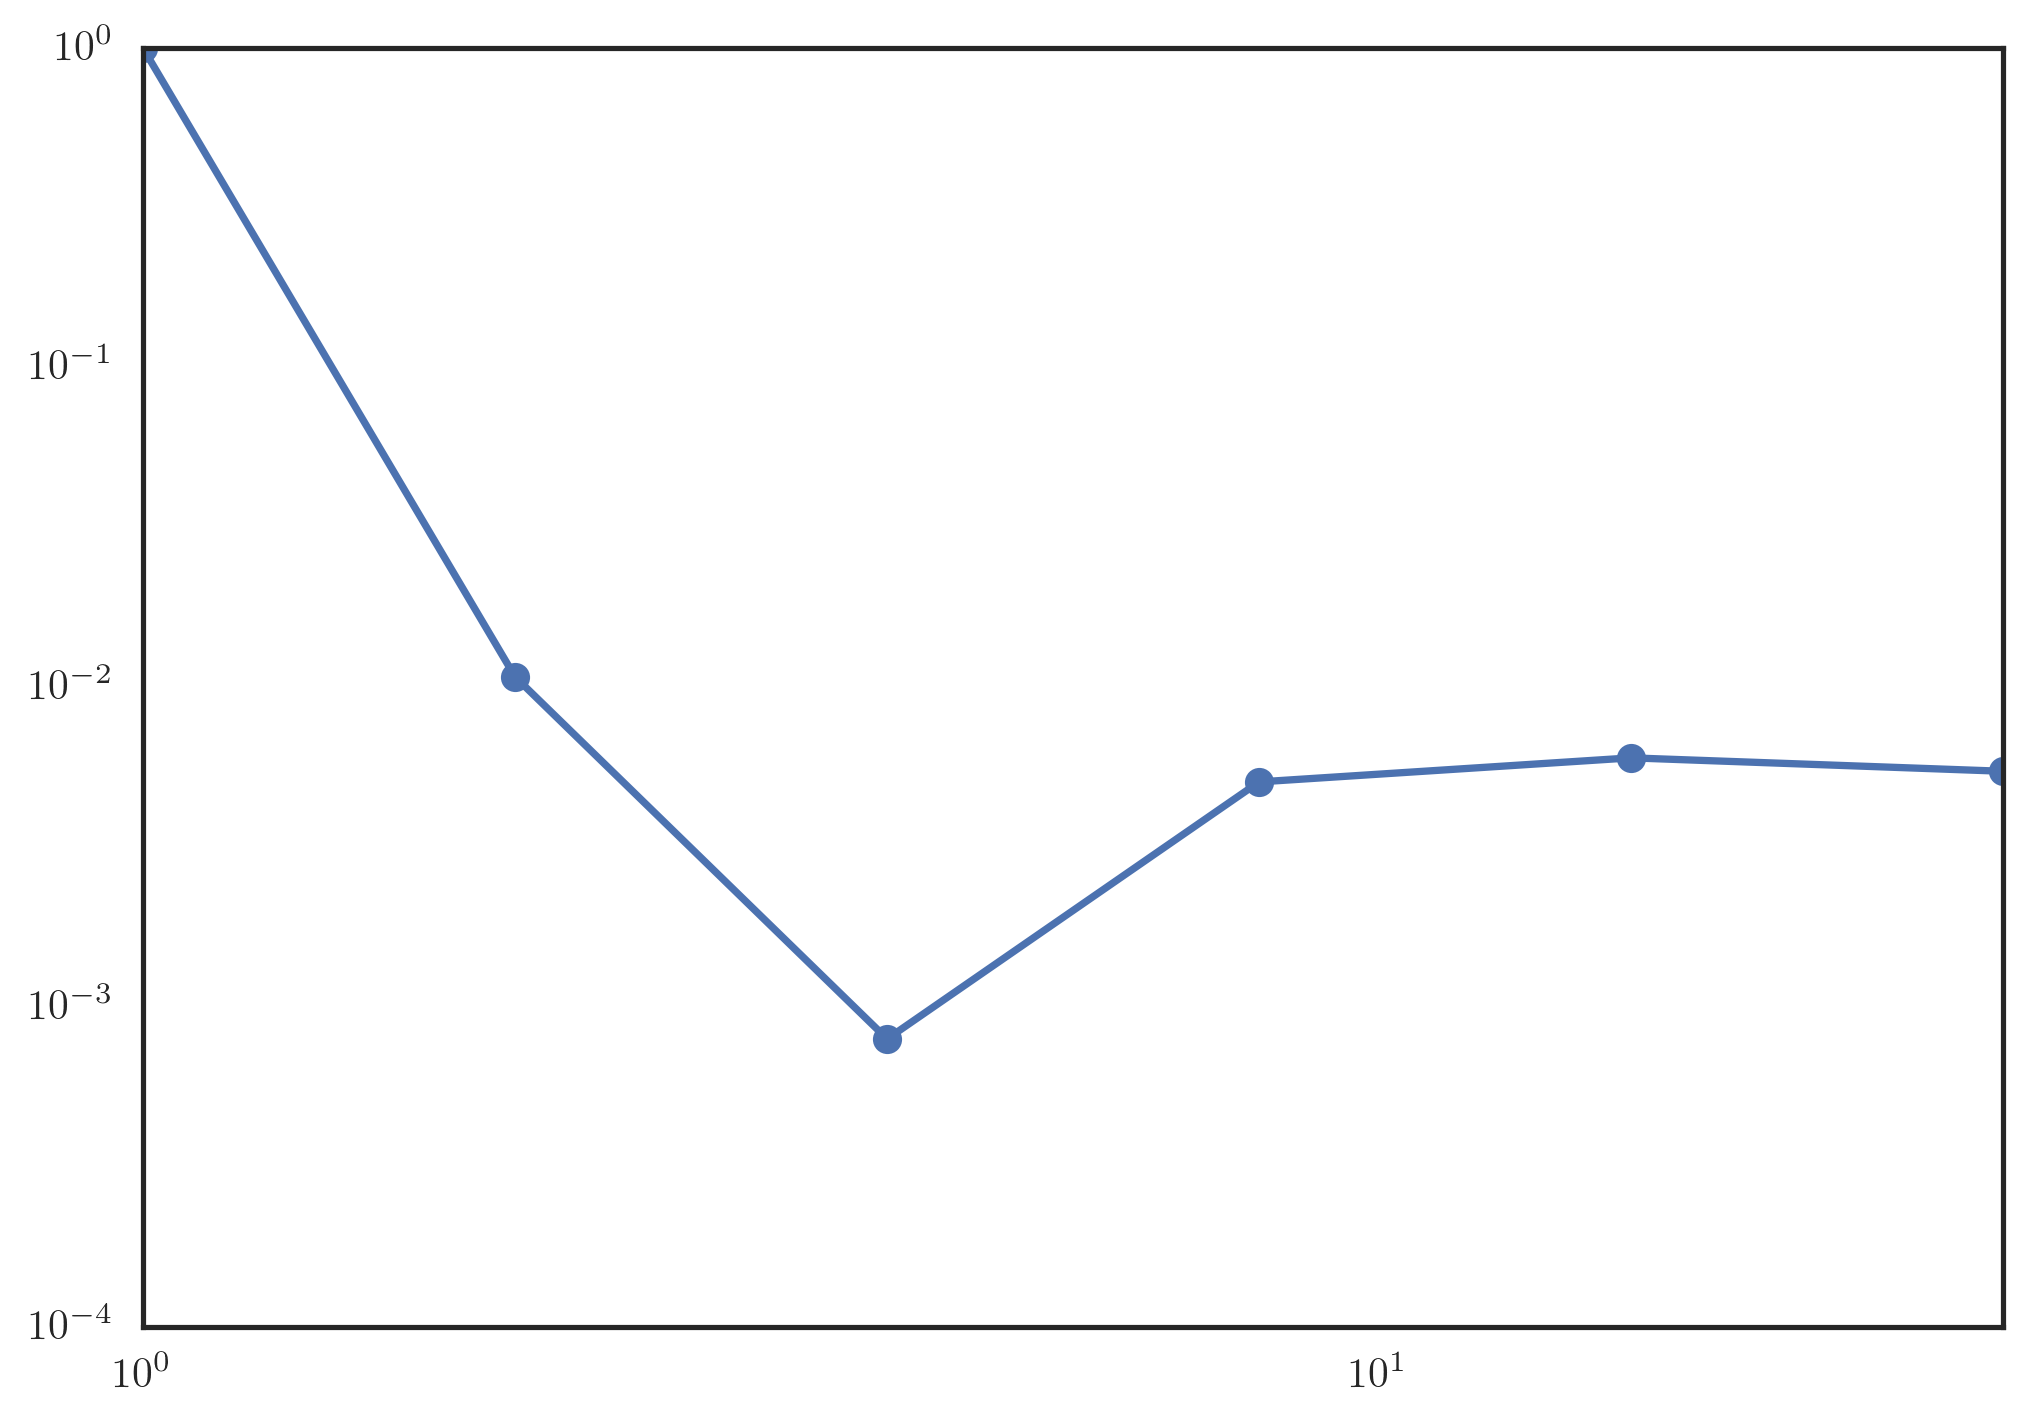

In [12]:
r2s = []
for col in fixed_n_logbin:
    model_values = utils.deg_dist_theory(col, fixed_n_logbin[col].dropna().index)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fixed_n_logbin[col].dropna().values, model_values)
    r2s.append(r_value**2)
display(pd.Series(r2s, index=fixed_n_logbin.columns))
pd.Series(r2s, index=fixed_n_logbin.columns).plot(style='-o', loglog=True)

# Fixed m and varying N

In [13]:
from collections import Counter

folder = "data/ba/deg_dist"
powers_of_n = np.arange(2, 8)
N = 10**powers_of_n
m = 4
df = pd.DataFrame()
for n in N:
    print(n)
    # number of repeats
    data = []
    for i in range(1,100):
        folder_name = folder + str(i) + "/"
        filename = "{0}_{1}.txt".format(n, m)
        filepath = folder_name + filename
        with open(filepath, 'r') as f:
            reader = csv.reader(f)
            data_as_list = list(reader)
        x = data_as_list[0]
        x = [int(i) for i in x]
        data.append(x)
    counters = [Counter(x) for x in data]
    sums = dict(sum(counters, Counter()))
    data_mean = {x: float(sums[x]) / len(data) for x in sums.keys()}
    additional = pd.DataFrame.from_dict(data_mean, orient="index")
    additional.columns = [n]
    df = pd.concat([df, additional], axis=1)

100
1000
10000
100000
1000000
10000000


## estimating errors on k1

In [14]:
max_k_all = []
for n in N:
    print(n)
    max_k = []
    for i in range(1, 100):
        folder_name = folder + str(i) + "/"
        filename = "{0}_{1}.txt".format(n, m)
        filepath = folder_name + filename
        with open(filepath, 'r') as f:
            reader = csv.reader(f)
            data_as_list = list(reader)
        x = data_as_list[0]
        x = [int(i) for i in x]
        k1 = utils.second_largest(x)
        max_k.append(k1)
    max_k_all.append(max_k)
max_k_df = pd.DataFrame(max_k_all, index=N).T

100
1000
10000
100000
1000000
10000000


In [15]:
max_k_df.describe()

,100,1000,10000,100000,1000000,10000000
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,39.313131,124.919192,396.383838,1248.212121,3924.727273,12558.595960
std,9.774651,30.497466,103.598194,332.149809,914.665745,2985.575906
min,24.000000,67.000000,213.000000,784.000000,2056.000000,6544.000000
25%,31.000000,102.500000,329.500000,1012.500000,3254.000000,10589.500000
50%,38.000000,119.000000,380.000000,1162.000000,3792.000000,11849.000000
75%,45.500000,142.500000,462.000000,1408.000000,4524.000000,14125.000000
max,63.000000,200.000000,799.000000,2171.000000,6334.000000,22314.000000


In [16]:
degrees_df = df

for col in degrees_df:
    total = degrees_df[col].dropna().sum()
    degrees_df[col] = degrees_df[col] / total

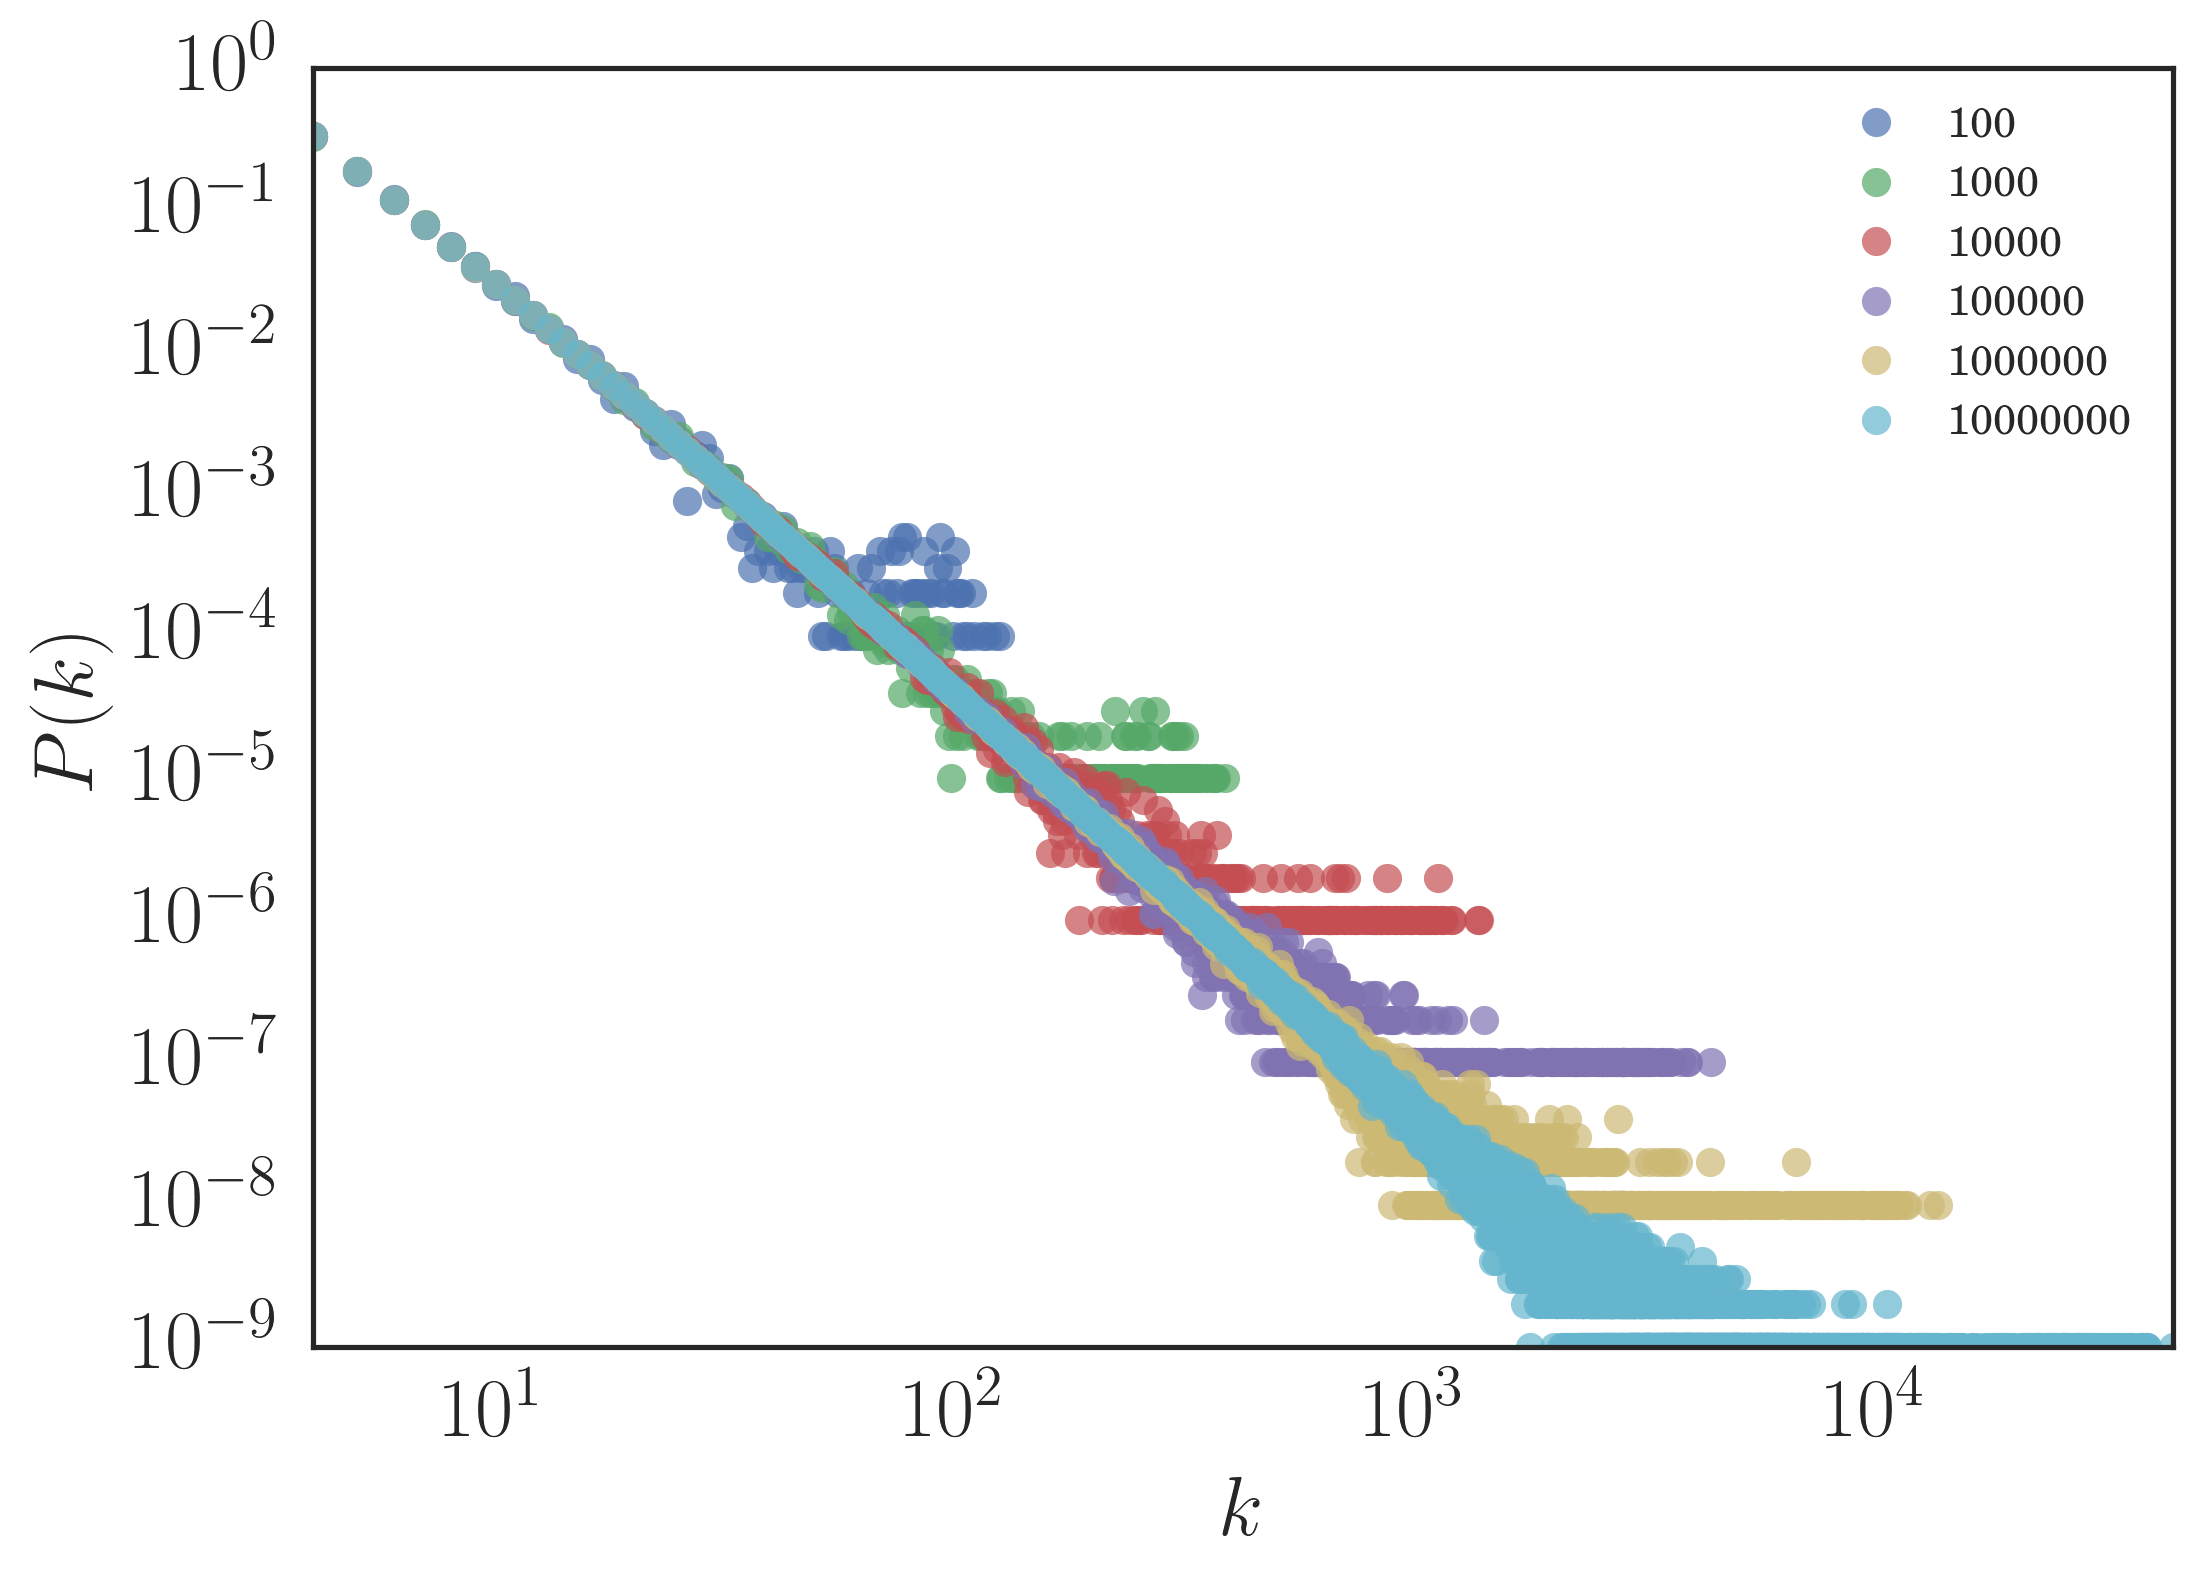

In [17]:
degrees_df.plot(loglog=True, style='o', alpha=0.7, fontsize=font_size)
ax = plt.gca()
ax.set_ylabel(u"$P(k)$", fontsize=font_size)
ax.set_xlabel(u'$k$', fontsize=font_size)

## log bin

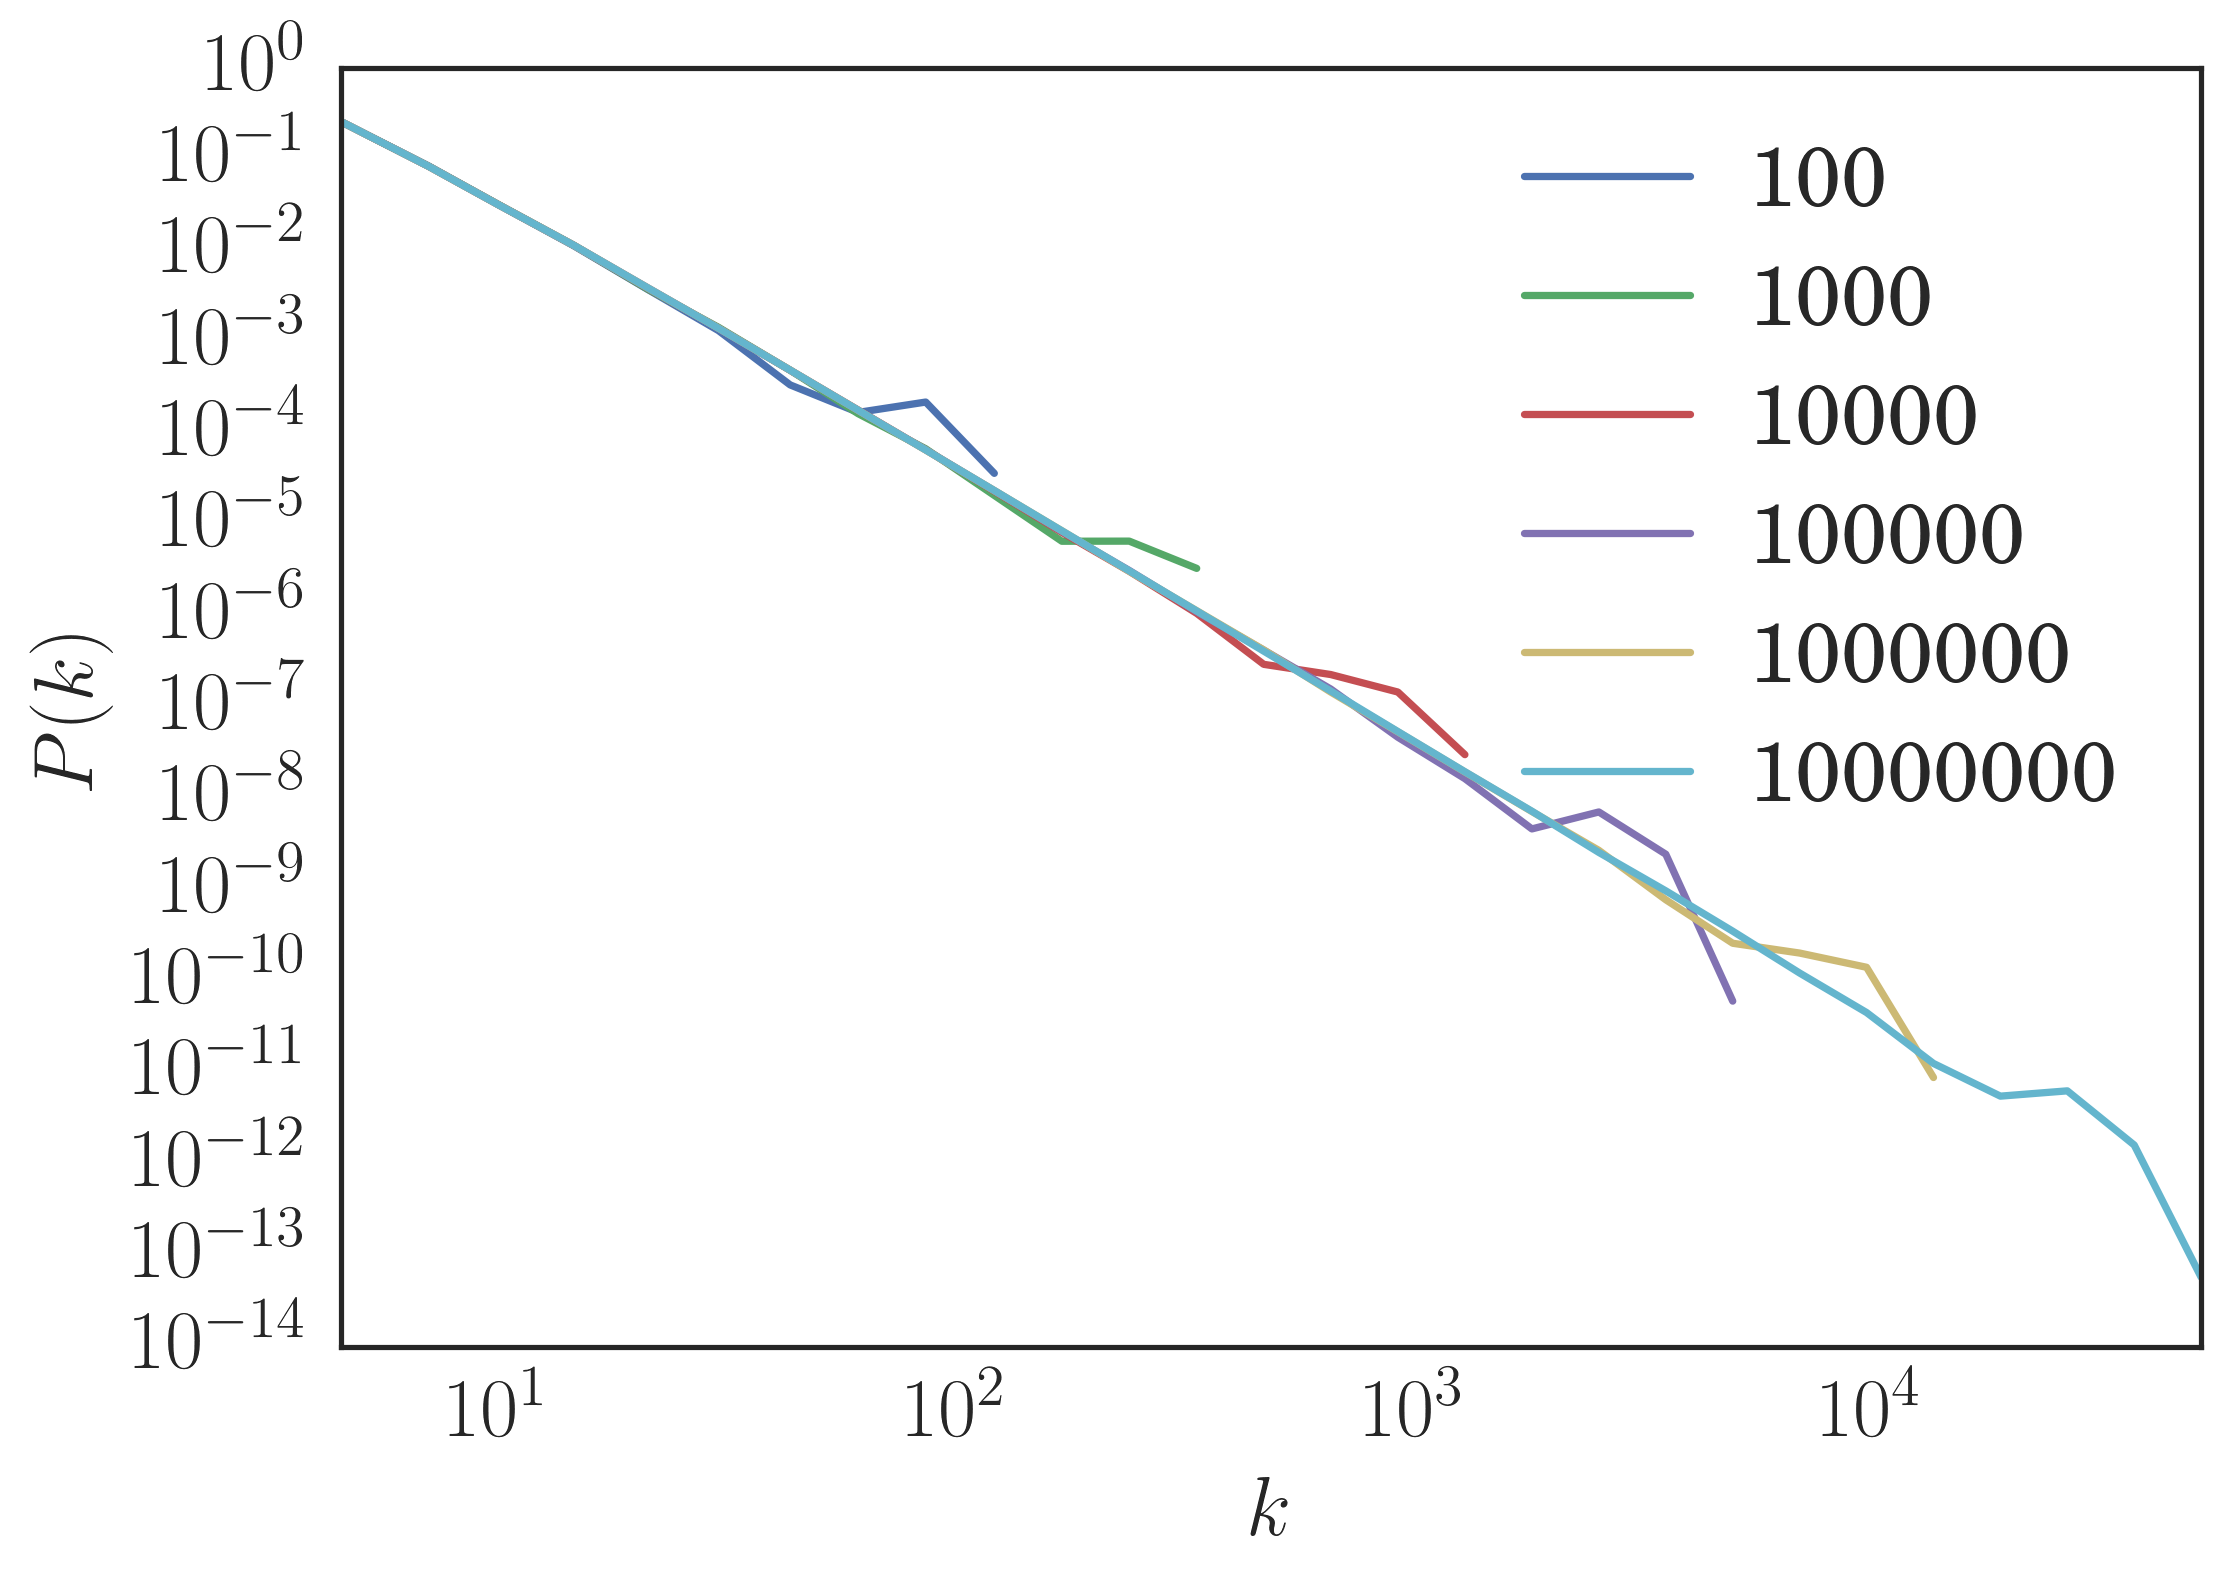

In [18]:
a = list(np.linspace(1.2, 1.5, len(degrees_df.columns)))
log_binned_df = utils.log_bin_freq_and_plot(degrees_df, a=1.4, style='-', loglog=True, font_size=font_size)
plt.legend(prop={'size':font_size})

There is a dip then a bump, and they seem equally spaced on a loglog plot, implying a power law governing finite size scaling effects. 

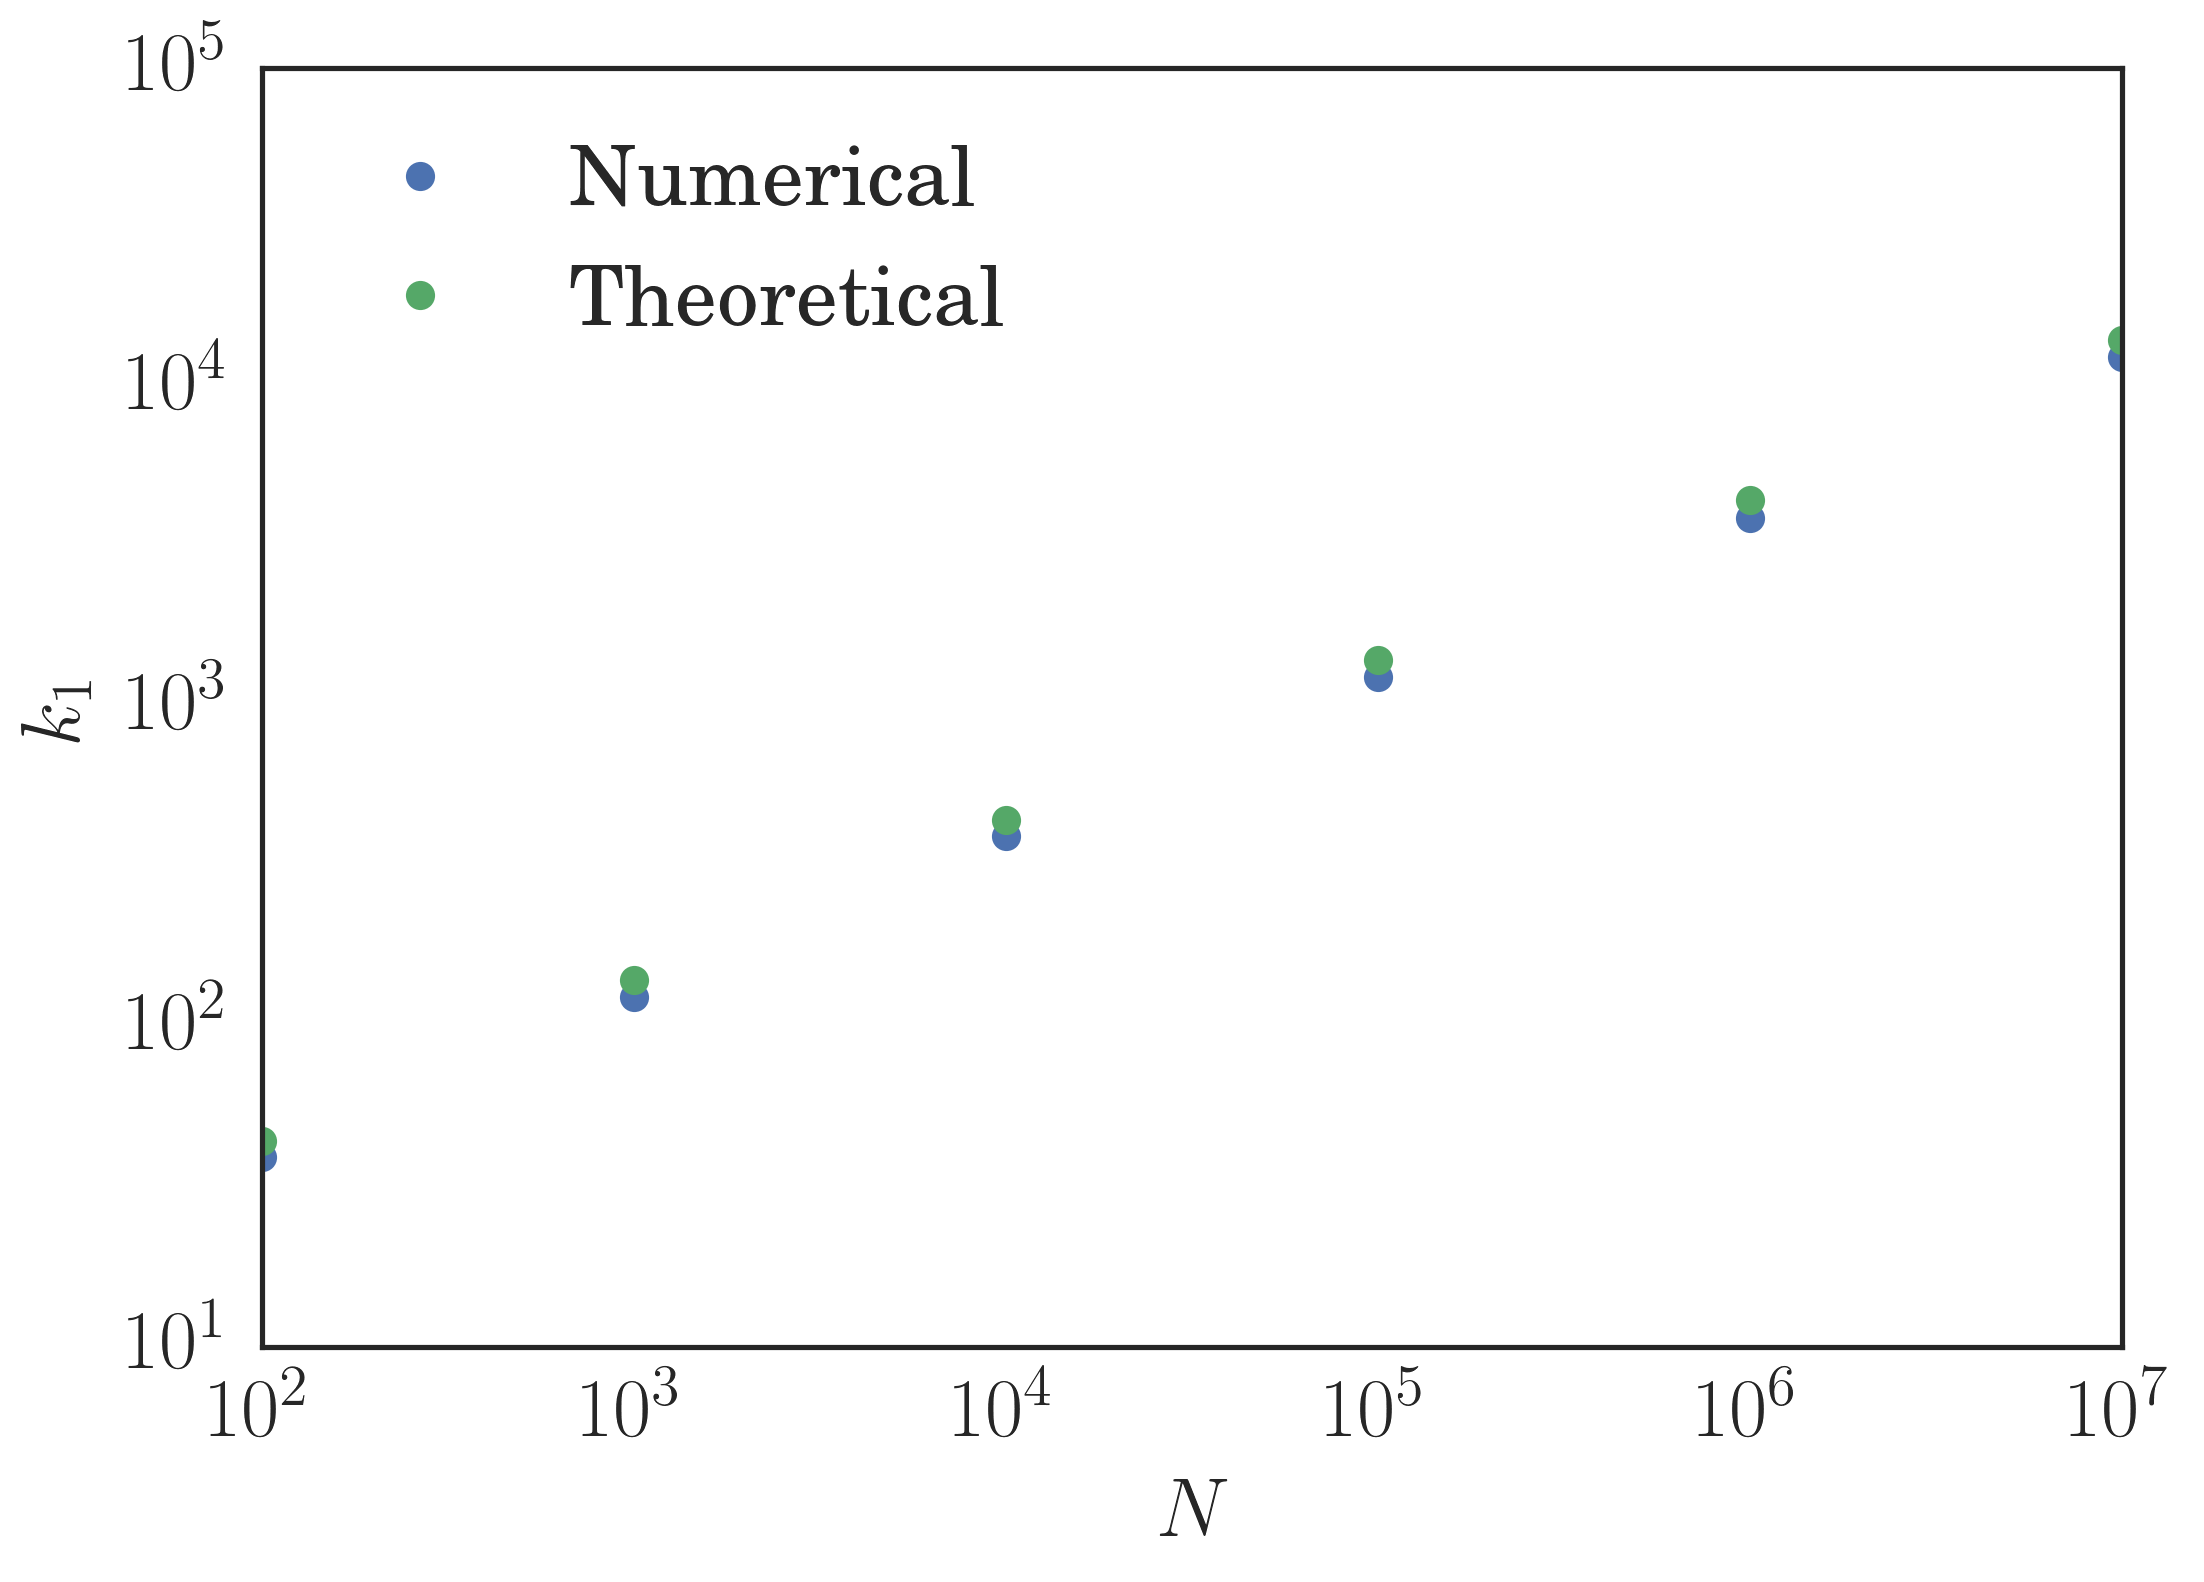

In [19]:
largest_expected_degree = []
largest_degree_theory = []
for col in max_k_df:
    a = max_k_df[col].mean()
    k1 = utils.largest_degree(col, m)
    largest_expected_degree.append(a)
    largest_degree_theory.append(k1)
current_palette = sns.color_palette()
numerical = pd.Series(largest_expected_degree, index=max_k_df.columns)
numerical.plot(style='o', loglog=True, label='Numerical')
theoretical = pd.Series(largest_degree_theory, index=max_k_df.columns)
theoretical.plot(marker='o', linestyle='None', color=current_palette[1],
                                                                loglog=True, label='Theoretical', fontsize=font_size)
ax = plt.gca()
plt.legend(prop={'size':font_size}, loc='best')
ax.set_ylabel(u"$k_1$", fontsize=font_size)
ax.set_xlabel(u"$N$", fontsize=font_size)

In [20]:
max_k_describe = max_k_df.describe()
for col in max_k_describe:
    max_k_describe[col]['std'] /= 100

max_k_describe

,100,1000,10000,100000,1000000,10000000
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,39.313131,124.919192,396.383838,1248.212121,3924.727273,12558.595960
std,0.097747,0.304975,1.035982,3.321498,9.146657,29.855759
min,24.000000,67.000000,213.000000,784.000000,2056.000000,6544.000000
25%,31.000000,102.500000,329.500000,1012.500000,3254.000000,10589.500000
50%,38.000000,119.000000,380.000000,1162.000000,3792.000000,11849.000000
75%,45.500000,142.500000,462.000000,1408.000000,4524.000000,14125.000000
max,63.000000,200.000000,799.000000,2171.000000,6334.000000,22314.000000


Numerical result is offset from the theoretical result by a constant value. We can then look at deviations from theoretical distribution for these systems. 

In [21]:
numerical

100            39.313131
1000          124.919192
10000         396.383838
100000       1248.212121
1000000      3924.727273
10000000    12558.595960
dtype: float64

In [22]:
theoretical

100            44.224155
1000          140.922240
10000         446.713875
100000       1413.713651
1000000      4471.635983
10000000    14141.635633
dtype: float64

In [23]:
numerical / theoretical

100         0.888952
1000        0.886441
10000       0.887333
100000      0.882931
1000000     0.877694
10000000    0.888058
dtype: float64

## Data collapse

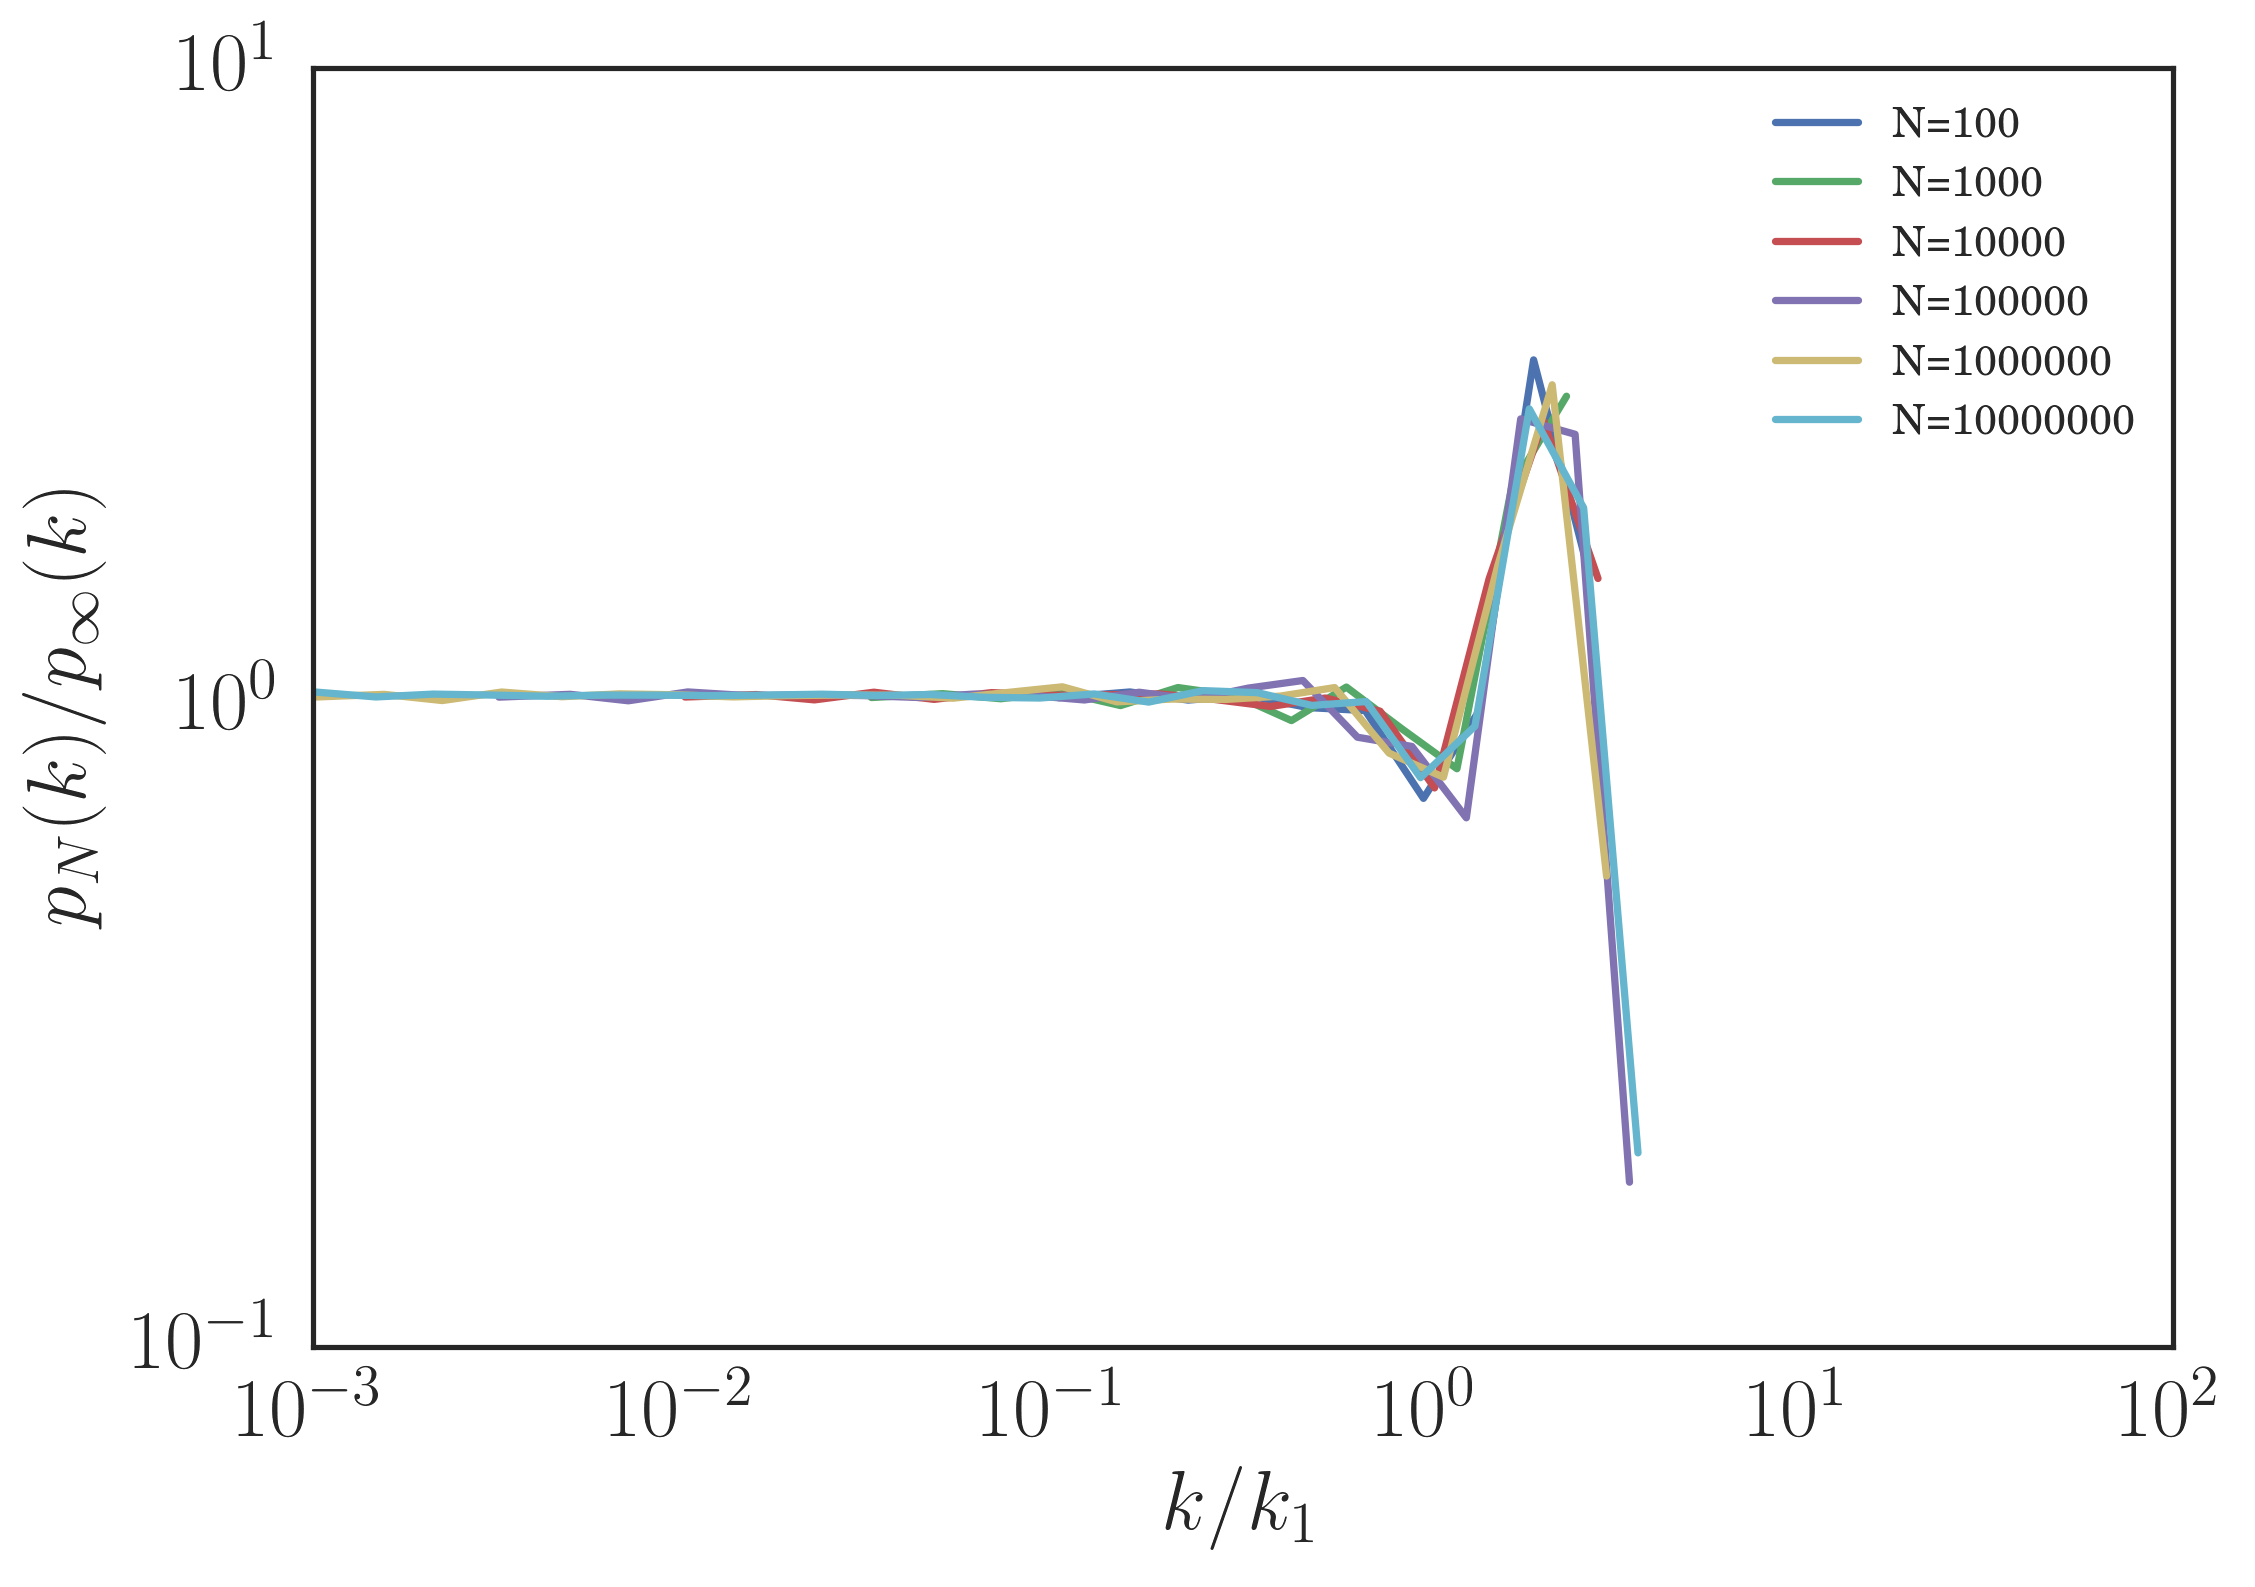

In [24]:
# using theoretical k1
data_collapse = log_binned_df
ax = plt.figure().gca()
for col in data_collapse:
    temp = pd.DataFrame()
    temp['y'] = data_collapse[col].dropna() / utils.deg_dist_theory(m, data_collapse[col].dropna().index.values)
    temp['x'] = data_collapse[col].dropna().index.values / utils.largest_degree(col, m)
    temp[temp != 0].plot(x='x', y='y', loglog=True, ax=ax, label="N=" + str(col), xlim=(1e-3, 1e2), fontsize=font_size)

ax.set_ylabel(u'$p_N(k) / p_{\infty}(k)$', fontsize=font_size)
ax.set_xlabel(u'$k/k_1$', fontsize=font_size)

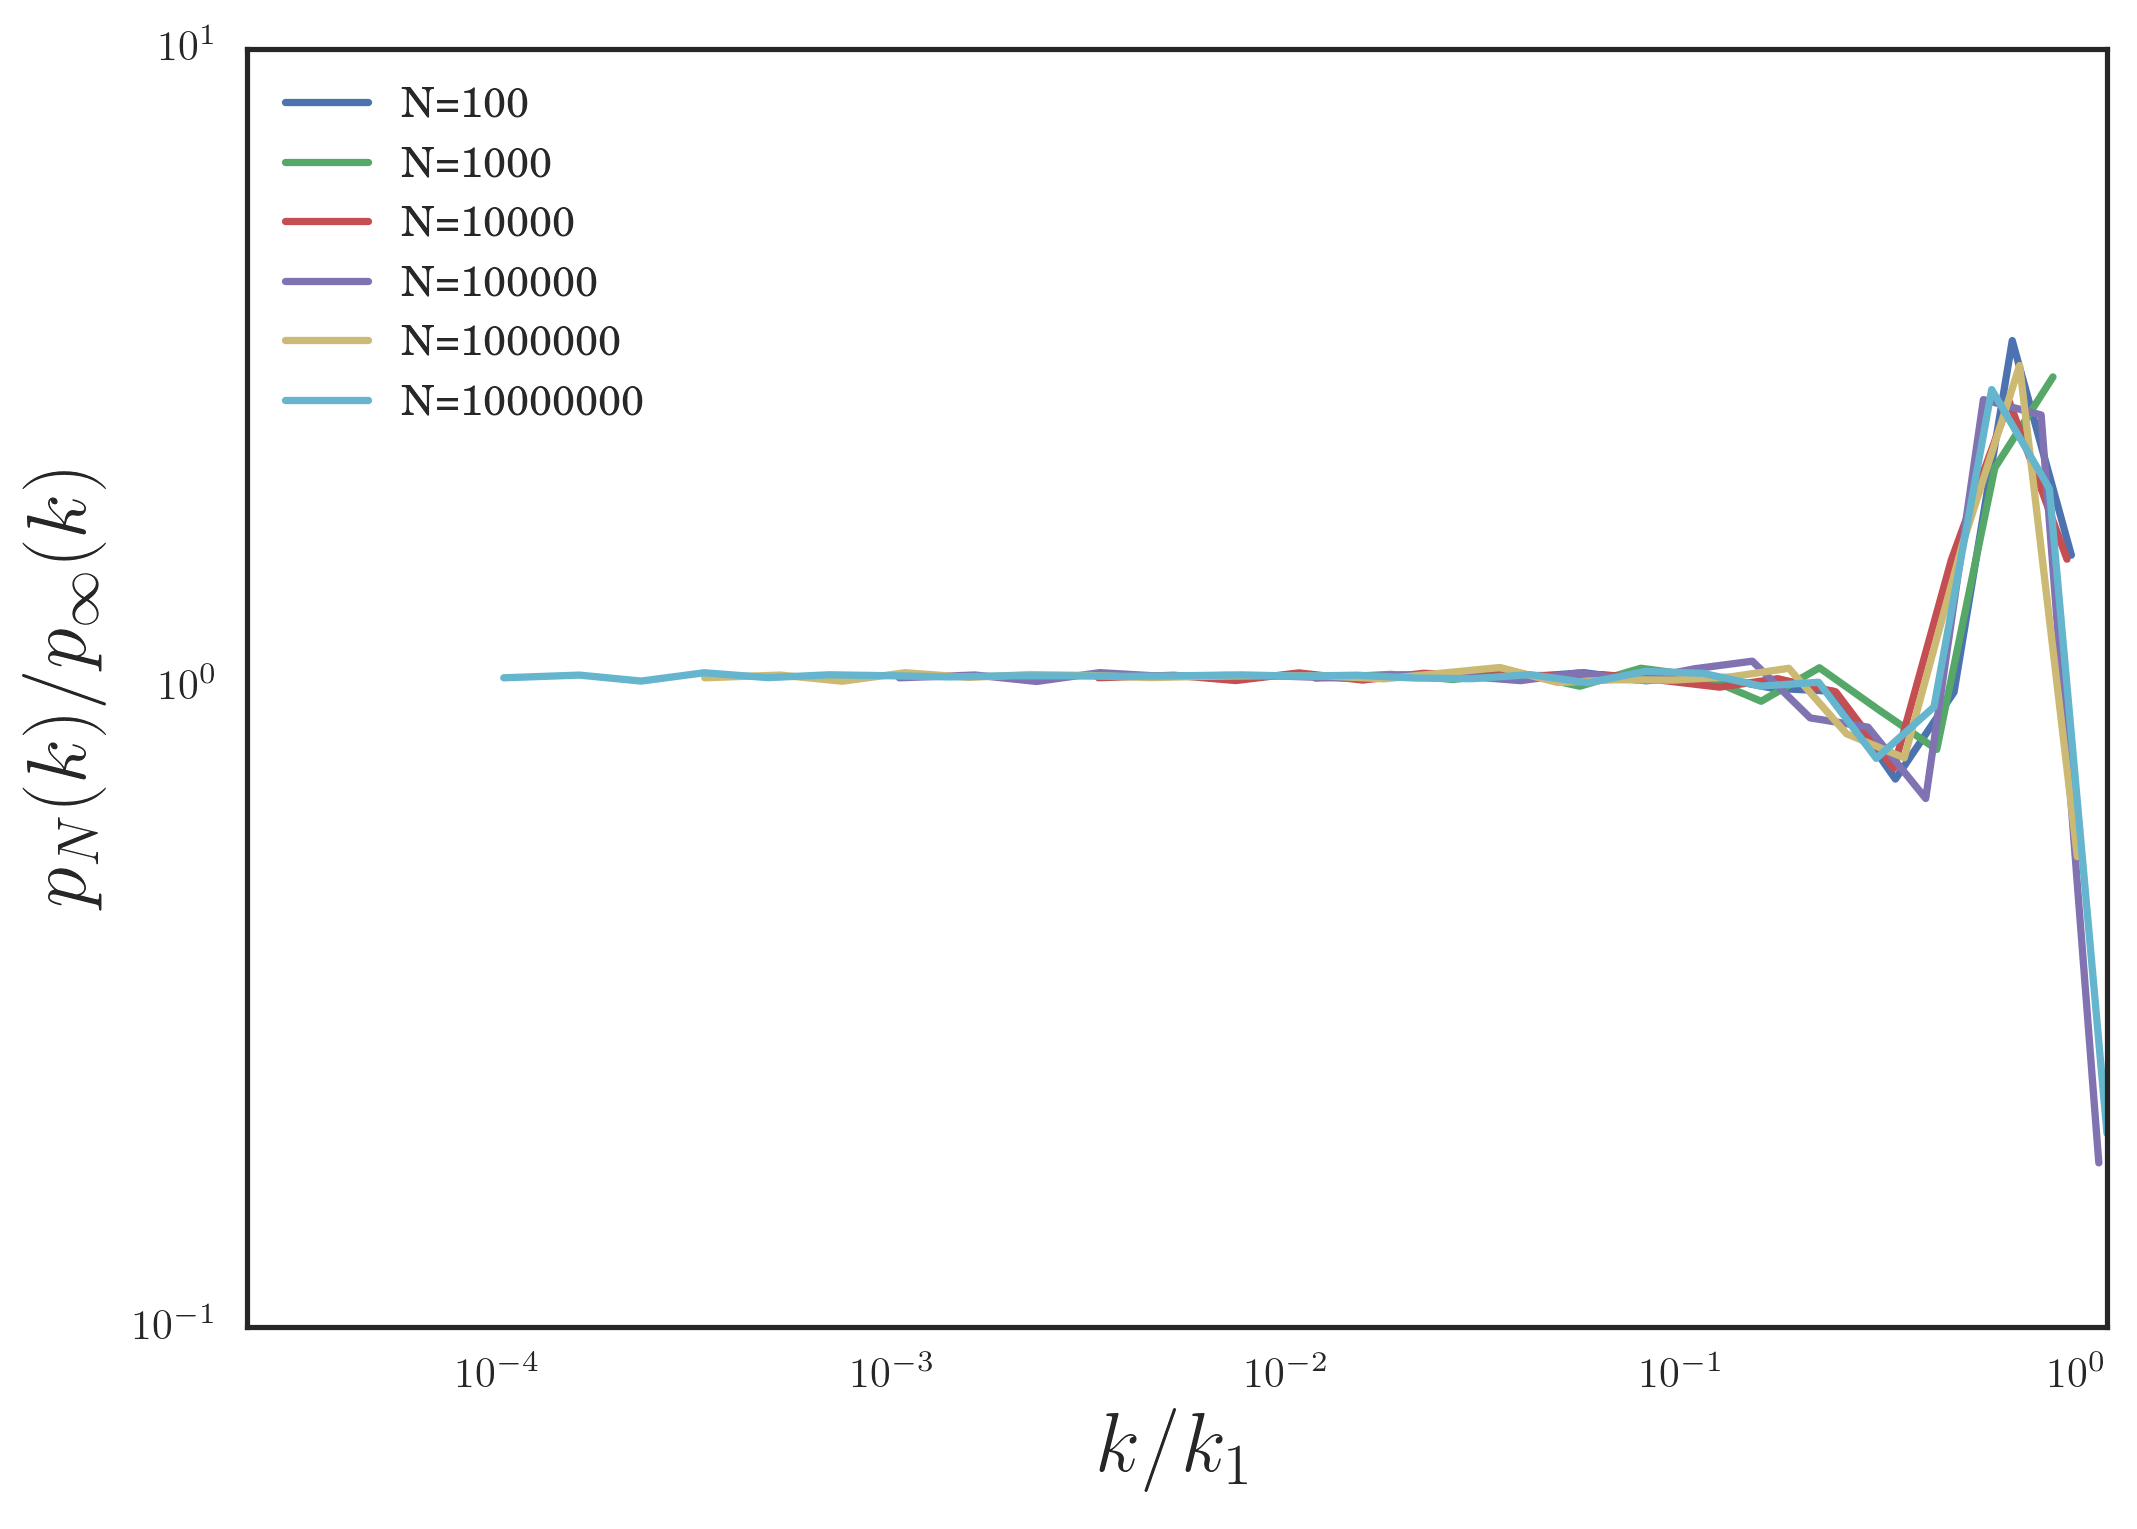

In [25]:
# using observed k1
data_collapse = log_binned_df
ax = plt.figure().gca()
for col in data_collapse:
    temp = pd.DataFrame()
    temp['y'] = data_collapse[col].dropna() / utils.deg_dist_theory(m, data_collapse[col].dropna().index.values)
    k1 = degrees_df[col].dropna()[degrees_df[col] != 0].tail(1).index.values[0]
    temp['x'] = data_collapse[col].dropna().index.values / k1
    temp[temp != 0].plot(x='x', y='y', loglog=True, ax=ax, label="N=" + str(col))

ax.set_ylabel(u'$p_N(k) / p_{\infty}(k)$', fontsize=font_size)
ax.set_xlabel(u'$k/k_1$', fontsize=font_size)